In [2]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import cophenet, fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns

# IMPORT DATA

In [3]:
df = pd.read_excel("D:/COLLEGE/MAGANG/BPBD/PROJEK KONVERSI/DATA KEJADIAN BPBD NEW.xlsx")
df.head()

,TANGGAL,JENIS KEJADIAN,JENIS LAKA,KECAMATAN,KELURAHAN,WILAYAH,LOKASI,OPEN TICKET,WAKTU TIBA,WAKTU RESPON,...,TINDAK LANJUT DM,PUSKESMAS,TIMPAHAN P. TUMBANG,JENIS POHON,PENYEBAB ROBOH,YANG TERBAKAR,JENIS PSIKOSOSIAL,JENIS HEWAN,JAM KE-,RUAS JALAN
0,2023-01-01,Kecelakaan,Tunggal,Tegalsari,Dr. Soetomo,Surabaya Pusat,Jln. Diponegoro No.121,01:16:44,01:22:12,00:05:28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JAM KE-1,Jl. Diponegoro
1,2023-01-01,Kecelakaan,Tunggal,Wonokromo,Ngagel Rejo,Surabaya Selatan,Jln. Bratang Gede No.112,02:09:53,02:16:22,00:06:29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JAM KE-1,NaN
2,2023-01-01,Kecelakaan,R2 Vs R4,Genteng,Embong Kaliasin,Surabaya Pusat,Depan BAPEM Jl. Gubernur Suryo No.15,02:14:39,02:19:00,00:04:21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JAM KE-1,NaN
3,2023-01-01,Darurat Medis,NaN,Jambangan,Kebonsari,Surabaya Selatan,Jln. Kebonsari VI No.12 C,02:37:36,02:44:35,00:06:59,...,Rujukan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JAM KE-1,NaN
4,2023-01-01,Darurat Medis,NaN,Dukuh Pakis,Pradah Kalikendal,Surabaya Selatan,Jln. Pradah Indah III No.05,02:47:23,02:54:12,00:06:49,...,Kematian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JAM KE-1,NaN


In [4]:
# Filter data untuk kelurahan 'beringin'
df_beringin = df[df['KELURAHAN'] == 'Beringin']
df_beringin

,TANGGAL,JENIS KEJADIAN,JENIS LAKA,KECAMATAN,KELURAHAN,WILAYAH,LOKASI,OPEN TICKET,WAKTU TIBA,WAKTU RESPON,...,TINDAK LANJUT DM,PUSKESMAS,TIMPAHAN P. TUMBANG,JENIS POHON,PENYEBAB ROBOH,YANG TERBAKAR,JENIS PSIKOSOSIAL,JENIS HEWAN,JAM KE-,RUAS JALAN
8095,2023-08-03,Kebakaran,NaN,Sambikerep,Beringin,Surabaya Barat,Jl. Raya Bringin Indah No.81,14:39:45,14:39:45,00:00:00,...,NaN,NaN,NaN,NaN,NaN,Lahan Kosong,NaN,NaN,JAM KE-1,NaN
16102,2024-02-03,Psikososial,NaN,Sambikerep,Beringin,Surabaya Barat,Jl. Alas Malang,19:49:52,19:55:21,00:05:29,...,NaN,NaN,NaN,NaN,NaN,NaN,Penemuan Bayi,NaN,JAM KE-24,NaN


In [5]:
# Ubah kolom 'TANGGAL' ke format datetime
df['TANGGAL'] = pd.to_datetime(df['TANGGAL'], format="%Y-%m-%d")

# Filter jenis kejadian yang ingin dianalisis
jenis_kejadian = ['Darurat Medis', 'Genangan', 'Kebakaran', 'Kecelakaan', 'Pohon Tumbang', 'Rumah Roboh']
df_filtered = df[df['JENIS KEJADIAN'].isin(jenis_kejadian)]

# Filter data antara bulan Oktober hingga Maret (termasuk periode lintas tahun)
df_filtered = df_filtered[(df_filtered['TANGGAL'].dt.month >= 11) | 
                          (df_filtered['TANGGAL'].dt.month <= 3)]

df_filtered['KELURAHAN'] = df_filtered['KELURAHAN'].str.lower()

# Tampilkan 5 data teratas hasil filter
df_filtered.head()

,TANGGAL,JENIS KEJADIAN,JENIS LAKA,KECAMATAN,KELURAHAN,WILAYAH,LOKASI,OPEN TICKET,WAKTU TIBA,WAKTU RESPON,...,TINDAK LANJUT DM,PUSKESMAS,TIMPAHAN P. TUMBANG,JENIS POHON,PENYEBAB ROBOH,YANG TERBAKAR,JENIS PSIKOSOSIAL,JENIS HEWAN,JAM KE-,RUAS JALAN
0,2023-01-01,Kecelakaan,Tunggal,Tegalsari,dr. soetomo,Surabaya Pusat,Jln. Diponegoro No.121,01:16:44,01:22:12,00:05:28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JAM KE-1,Jl. Diponegoro
1,2023-01-01,Kecelakaan,Tunggal,Wonokromo,ngagel rejo,Surabaya Selatan,Jln. Bratang Gede No.112,02:09:53,02:16:22,00:06:29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JAM KE-1,NaN
2,2023-01-01,Kecelakaan,R2 Vs R4,Genteng,embong kaliasin,Surabaya Pusat,Depan BAPEM Jl. Gubernur Suryo No.15,02:14:39,02:19:00,00:04:21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JAM KE-1,NaN
3,2023-01-01,Darurat Medis,NaN,Jambangan,kebonsari,Surabaya Selatan,Jln. Kebonsari VI No.12 C,02:37:36,02:44:35,00:06:59,...,Rujukan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JAM KE-1,NaN
4,2023-01-01,Darurat Medis,NaN,Dukuh Pakis,pradah kalikendal,Surabaya Selatan,Jln. Pradah Indah III No.05,02:47:23,02:54:12,00:06:49,...,Kematian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JAM KE-1,NaN


In [6]:
df_filtered.tail()

,TANGGAL,JENIS KEJADIAN,JENIS LAKA,KECAMATAN,KELURAHAN,WILAYAH,LOKASI,OPEN TICKET,WAKTU TIBA,WAKTU RESPON,...,TINDAK LANJUT DM,PUSKESMAS,TIMPAHAN P. TUMBANG,JENIS POHON,PENYEBAB ROBOH,YANG TERBAKAR,JENIS PSIKOSOSIAL,JENIS HEWAN,JAM KE-,RUAS JALAN
18582,2024-03-31,Kebakaran,NaN,Pabean Cantian,krembangan utara,Surabaya Utara,Muteran Gg. III,21:41:50,21:45:00,00:03:10,...,NaN,NaN,NaN,NaN,NaN,Hunian,NaN,NaN,JAM KE-24,NaN
18583,2024-03-31,Darurat Medis,NaN,Tegalsari,keputran,Surabaya Pusat,Dinoyo Baru Gang kantong No 40 B,21:45:25,21:52:00,00:06:35,...,Penanganan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JAM KE-24,NaN
18584,2024-03-31,Darurat Medis,NaN,Wiyung,balas klumprik,Surabaya Selatan,"Jl.Perum pondok maritim Blok DD no 15,",22:23:15,22:28:00,00:04:45,...,Rujukan,Balas Klumprik,NaN,NaN,NaN,NaN,NaN,NaN,JAM KE-24,NaN
18585,2024-03-31,Kecelakaan,R2 Vs R2,Tambaksari,tambaksari,Surabaya Timur,Jl. Ploso Bogen No.29,22:30:03,22:37:00,00:06:57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JAM KE-24,NaN
18586,2024-03-31,Darurat Medis,NaN,Asem Rowo,asem rowo,Surabaya Barat,Greges Bar. Gg. Mulyo No.140,23:14:56,23:21:00,00:06:04,...,Rujukan,Asem Rowo,NaN,NaN,NaN,NaN,NaN,NaN,JAM KE-24,NaN


# DATA UNDERSTANDING

In [7]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9537 entries, 0 to 18586
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   TANGGAL              9537 non-null   datetime64[ns]
 1   JENIS KEJADIAN       9537 non-null   object        
 2   JENIS LAKA           4077 non-null   object        
 3   KECAMATAN            9537 non-null   object        
 4   KELURAHAN            9537 non-null   object        
 5   WILAYAH              9537 non-null   object        
 6   LOKASI               9537 non-null   object        
 7   OPEN TICKET          9537 non-null   object        
 8   WAKTU TIBA           9537 non-null   object        
 9   WAKTU RESPON         9536 non-null   object        
 10  L                    5159 non-null   object        
 11  P                    3813 non-null   object        
 12  0-5                  88 non-null     float64       
 13  6-18                 621 non-null    

In [8]:
df_filtered.isna().sum()

TANGGAL                   0
JENIS KEJADIAN            0
JENIS LAKA             5460
KECAMATAN                 0
KELURAHAN                 0
WILAYAH                   0
LOKASI                    0
OPEN TICKET               0
WAKTU TIBA                0
WAKTU RESPON              1
L                      4378
P                      5724
0-5                    9449
6-18                   8916
19-44                  6929
45-100                 6007
SURABAYA               4626
NON SURABAYA           8089
TIDAK DIKETAHUI        9489
KORBAN TERDAMPAK         35
KORBAN LUKA              35
KORBAN MENINGGAL         35
TINDAK LANJUT DM       5065
PUSKESMAS              8411
TIMPAHAN P. TUMBANG    9223
JENIS POHON            9388
PENYEBAB ROBOH         9395
YANG TERBAKAR          9158
JENIS PSIKOSOSIAL      9537
JENIS HEWAN            9535
JAM KE-                   0
RUAS JALAN             8348
dtype: int64

# STATISTIKA DESKRIPTIF

C:\Users\Selayanti\AppData\Local\Temp\ipykernel_14632\1364939599.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=kejadian_counts.index, y=kejadian_counts.values, palette='muted')


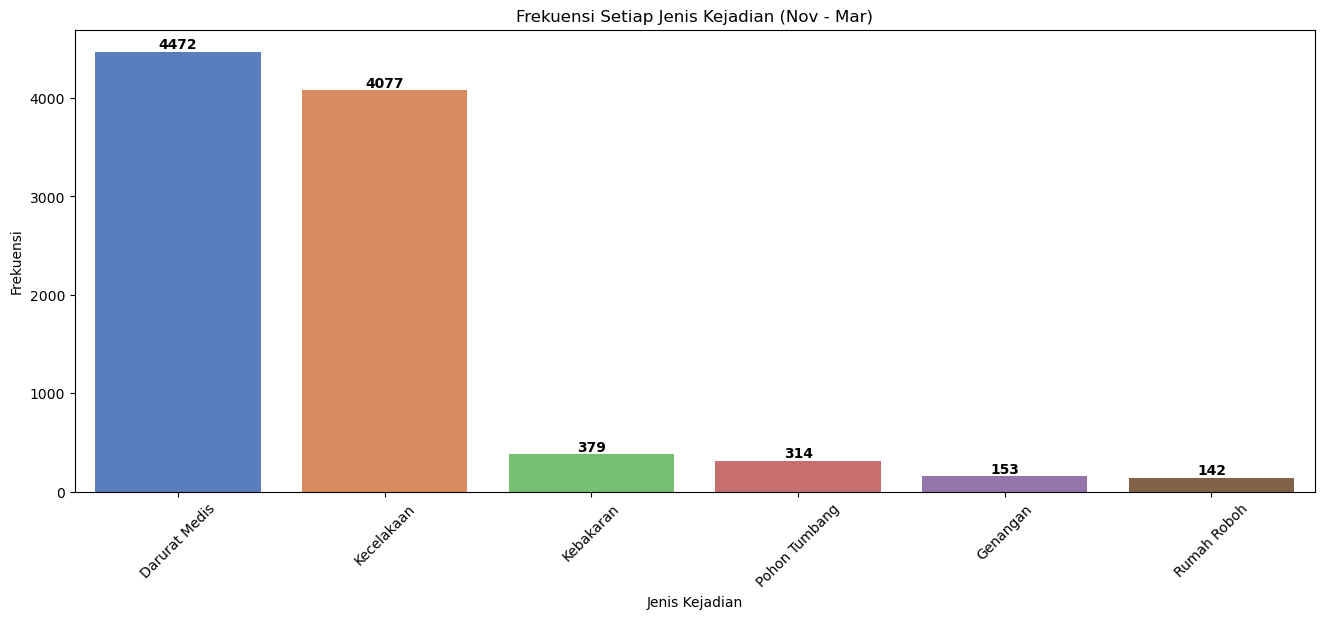

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung frekuensi kejadian per jenis kejadian
kejadian_counts = df_filtered['JENIS KEJADIAN'].value_counts()

# Plot barchart menggunakan seaborn
plt.figure(figsize=(16, 6))
ax = sns.barplot(x=kejadian_counts.index, y=kejadian_counts.values, palette='muted')

# Tambahkan angka di atas setiap bar
for i, v in enumerate(kejadian_counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Set judul dan label
plt.title('Frekuensi Setiap Jenis Kejadian (Nov - Mar)')
plt.xlabel('Jenis Kejadian')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.show()

  JENIS KEJADIAN  KORBAN LUKA KORBAN MENINGGAL  KORBAN TERDAMPAK
0  Darurat Medis     0.876090         0.124106          1.007379
1       Genangan     0.000000              0.0          0.006623
2      Kebakaran     0.142857         0.013736          1.663912
3     Kecelakaan     1.544428         0.020619          1.739323
4  Pohon Tumbang     0.013333              0.0          0.230000
5    Rumah Roboh     0.140845         0.007042          4.422535


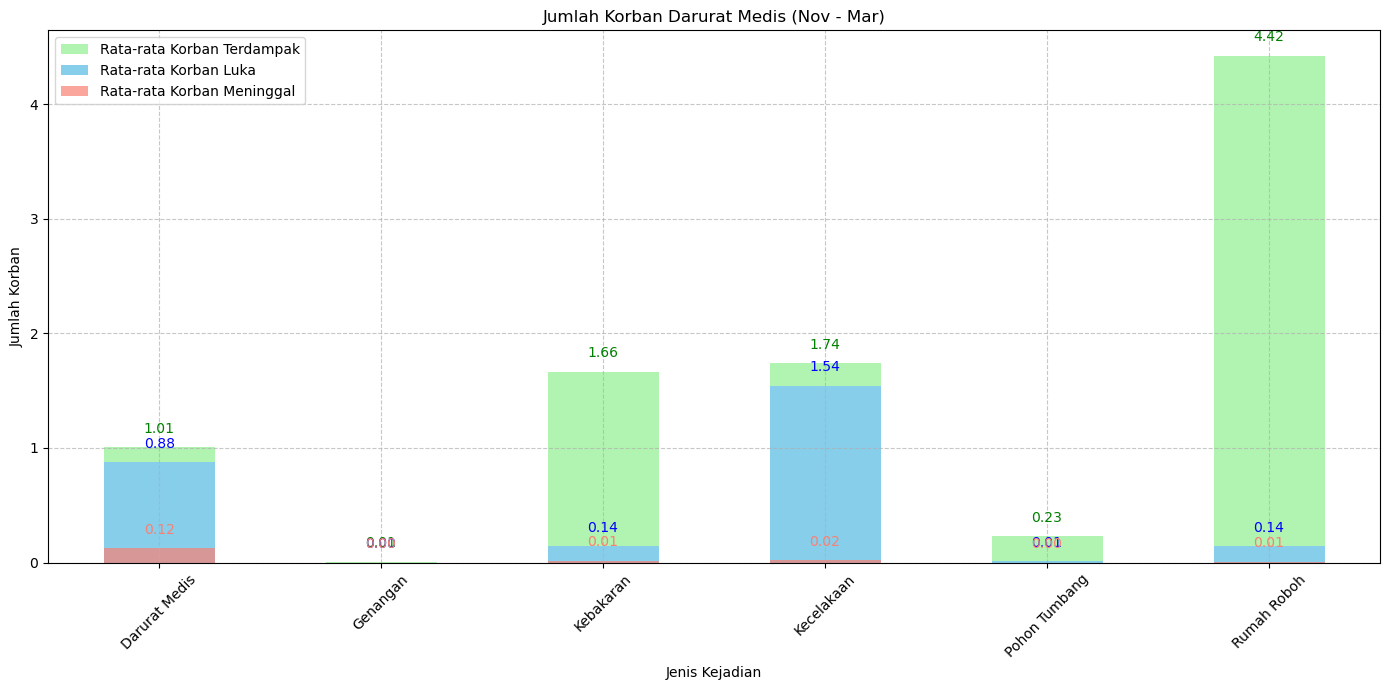

In [10]:
# Menghitung rata-rata korban luka, meninggal, dan terdampak per jenis kejadian berdasarkan df_filtered
impact_analysis = df_filtered.groupby('JENIS KEJADIAN').agg({
    'KORBAN LUKA': 'mean',
    'KORBAN MENINGGAL': 'mean',
    'KORBAN TERDAMPAK': 'mean'  # Tambahkan rata-rata korban terdampak
}).reset_index()

# Menampilkan hasil analisis dampak
print(impact_analysis)

# Visualisasi hasil analisis
fig, ax = plt.subplots(figsize=(14, 7))

# Plot rata-rata korban terdampak (di belakang)
impact_analysis.plot(
    kind='bar', 
    x='JENIS KEJADIAN', 
    y='KORBAN TERDAMPAK', 
    ax=ax, 
    color='lightgreen', 
    label='Rata-rata Korban Terdampak', 
    alpha=0.7
)

# Plot rata-rata korban luka
impact_analysis.plot(
    kind='bar', 
    x='JENIS KEJADIAN', 
    y='KORBAN LUKA', 
    ax=ax, 
    color='skyblue', 
    label='Rata-rata Korban Luka'
)

# Plot rata-rata korban meninggal
impact_analysis.plot(
    kind='bar', 
    x='JENIS KEJADIAN', 
    y='KORBAN MENINGGAL', 
    ax=ax, 
    color='salmon', 
    label='Rata-rata Korban Meninggal', 
    alpha=0.7
)

# Menambahkan angka pada grafik
for i, row in impact_analysis.iterrows():
    ax.text(i, row['KORBAN TERDAMPAK'] + 0.1, f'{row["KORBAN TERDAMPAK"]:.2f}', 
            ha='center', va='bottom', color='green')
    ax.text(i, row['KORBAN LUKA'] + 0.1, f'{row["KORBAN LUKA"]:.2f}', 
            ha='center', va='bottom', color='blue')
    ax.text(i, row['KORBAN MENINGGAL'] + 0.1, f'{row["KORBAN MENINGGAL"]:.2f}', 
            ha='center', va='bottom', color='salmon')

# Menyesuaikan tampilan grafik
ax.set_title('Jumlah Korban Darurat Medis (Nov - Mar)')
ax.set_xlabel('Jenis Kejadian')
ax.set_ylabel('Jumlah Korban')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

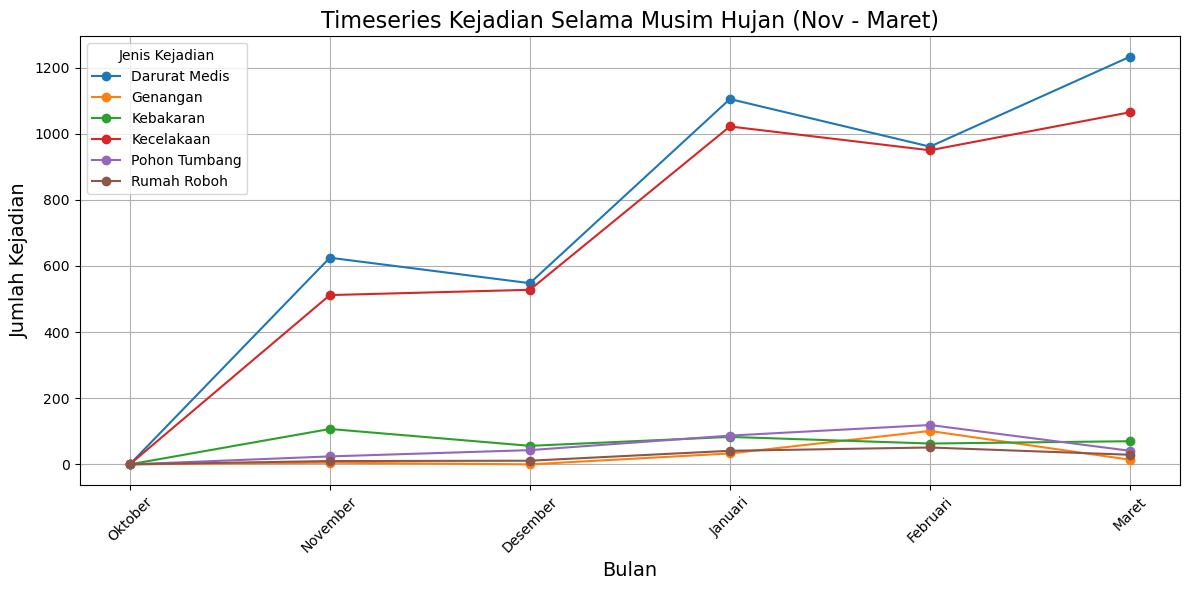

In [11]:
#Tambahkan kolom bulan untuk memudahkan analisis
df_filtered['BULAN'] = df_filtered['TANGGAL'].dt.month

# Filter data untuk bulan Oktober (10) hingga Maret (3)
# Kita akan menggunakan bulan 10 hingga 12 dan bulan 1 hingga 3
october_to_march = df_filtered[(df_filtered['BULAN'] >= 10) | (df_filtered['BULAN'] <= 3)]

# Tambahkan kolom untuk bulan sebagai nama bulan untuk kemudahan penamaan
month_mapping = {10: 'Oktober', 11: 'November', 12: 'Desember', 1: 'Januari', 2: 'Februari', 3: 'Maret'}
october_to_march['NAMA BULAN'] = october_to_march['BULAN'].map(month_mapping)

# Kelompokkan data berdasarkan 'NAMA BULAN' dan 'JENIS KEJADIAN' dan hitung jumlah kejadian
df_grouped = october_to_march.groupby(['NAMA BULAN', 'JENIS KEJADIAN']).size().unstack(fill_value=0)

# Atur urutan bulan agar sesuai
df_grouped = df_grouped.reindex(month_mapping.values(), fill_value=0)

# Plot line chart untuk semua jenis kejadian
plt.figure(figsize=(12, 6))
for column in df_grouped.columns:
    plt.plot(df_grouped.index, df_grouped[column], marker='o', label=column)

# Tambahkan judul dan label
plt.title('Timeseries Kejadian Selama Musim Hujan (Nov - Maret)', fontsize=16)
plt.xlabel('Bulan', fontsize=14)
plt.ylabel('Jumlah Kejadian', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Jenis Kejadian')
plt.grid()

# Tampilkan plot
plt.tight_layout()
plt.show()

- Dalam analisis kejadian selama musim hujan di kota ini, terlihat bahwa Darurat Medis menjadi kasus yang paling dominan. Kasus darurat medis menunjukkan pola yang cukup menarik, dimana di awal musim hujan (Oktober-Desember) kasusnya cenderung stabil di kisaran 600 kejadian, namun kemudian melonjak drastis di bulan Januari mencapai 1100 kasus. Meski sempat menurun di Februari, angkanya kembali naik di Maret hingga 1200 kasus. Hal ini mengindikasikan adanya korelasi antara cuaca ekstrem dengan kondisi kesehatan masyarakat. Peningkatan di bulan Maret juga dapat dikaitkan dengan periode Ramadhan, dimana terjadi perubahan pola aktivitas masyarakat yang bersamaan dengan kondisi musim hujan.

- Kecelakaan menjadi kejadian kedua terbanyak dengan pola yang hampir serupa dengan darurat medis. Tren kecelakaan meningkat tajam dari Desember ke Januari, mencapai puncaknya sekitar 1000 kasus. Fenomena ini kemungkinan terkait dengan kondisi jalan yang licin dan visibility yang berkurang saat hujan deras, ditambah dengan peningkatan mobilitas masyarakat di awal tahun. Lonjakan di bulan Maret bisa juga dipengaruhi oleh padatnya aktivitas mudik pada bulan puasa, dan menjelang berbuka puasa yang bertepatan dengan kondisi jalan basah dan rawan kecelakaan.

- Untuk kasus kebakaran, tren yang terlihat justru menurun sepanjang musim hujan. Dimulai dari sekitar 150 kasus di Oktober, angkanya terus berkurang hingga Maret. Ini merupakan pola yang masuk akal mengingat tingginya curah hujan mengurangi potensi kebakaran, meski tetap perlu diwaspadai terutama kebakaran yang disebabkan korsleting listrik akibat genangan air.

- Kejadian pohon tumbang dan rumah roboh menunjukkan peningkatan di pertengahan musim hujan, khususnya Januari. Ini berkorelasi dengan periode puncak musim hujan yang biasanya disertai angin kencang. Meski jumlahnya tidak sebanyak darurat medis atau kecelakaan, dampak dari kejadian ini bisa sangat serius bagi infrastruktur dan keselamatan warga.

**Insight penting yang bisa diambil:**

Terdapat pola musiman yang jelas dalam setiap jenis kejadian, dengan puncak intensitas di Januari-Maret untuk mayoritas kasus. Periode ini menjadi masa kritis yang membutuhkan kesiapsiagaan tinggi dari seluruh unit layanan darurat. Yang menarik adalah meski di musim hujan, jumlah kasus darurat medis dan kecelakaan justru meningkat signifikan, menunjukkan bahwa cuaca memiliki dampak tidak langsung terhadap kesehatan dan keselamatan masyarakat.
Rekomendasi penanganan:

- **Sistem Kesehatan :**
    1. Penguatan kapasitas unit gawat darurat terutama menjelang Januari-Maret
    2. Penyediaan stok obat-obatan dan peralatan medis yang lebih banyak
    3. Penambahan tenaga medis siaga di puskesmas dan rumah sakit

- **Infrastruktur dan Keselamatan :**
    1. Peningkatan maintenance drainase dan sistem penerangan jalan
    2. Pemeriksaan rutin kondisi pohon-pohon besar di sepanjang jalan
    3. Perbaikan infrastruktur jalan yang rawan genangan
    4. Program assessment dan perbaikan rumah warga yang berisiko roboh

- **Sistem Peringatan Dini :**
    1. Pengembangan sistem notifikasi cuaca ekstrem ke masyarakat
    2. Pemetaan zona rawan bencana berdasarkan data historis
    3. Sosialisasi protokol keselamatan musim hujan ke masyarakat

- **Manajemen Sumber Daya :**
    1. Koordinasi antar instansi (kesehatan, pemadam, SAR) yang lebih terstruktur
    2. Pelatihan regular untuk tim tanggap darurat
    3. Penyediaan alat berat dan peralatan rescue yang memadai

Dengan penanganan yang tepat dan terencana, diharapkan dampak dari berbagai kejadian di musim hujan ini bisa diminimalisir, terutama dari segi korban jiwa dan kerugian material.

## 1. Statistika Deskriptif Jenis Kejadian 'KECELAKAAN'

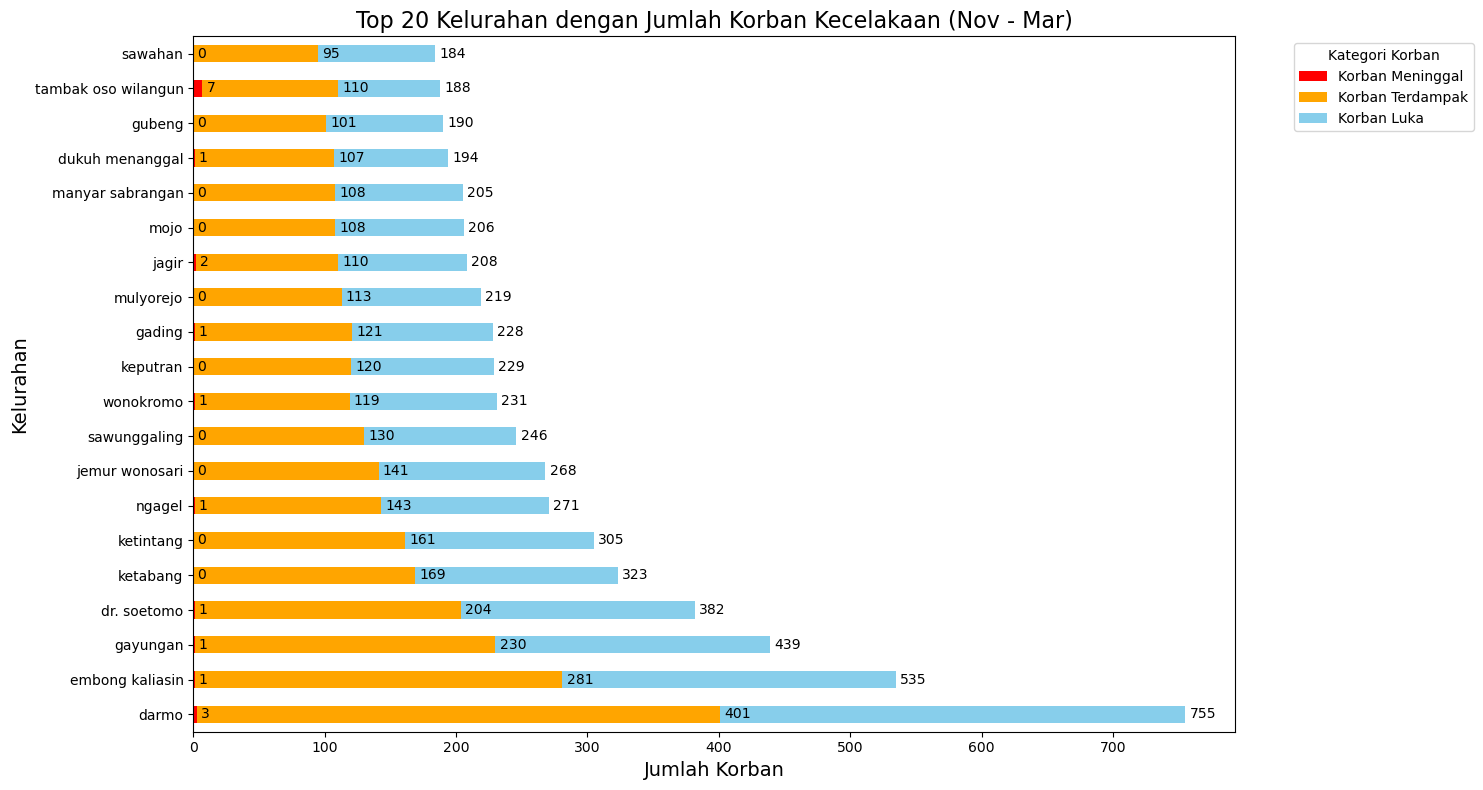

In [12]:
# Filter data untuk kejadian 'kecelakaan'
df_kecelakaan = df_filtered[df_filtered['JENIS KEJADIAN'].str.lower() == 'kecelakaan']

# Kelompokkan data berdasarkan 'KELURAHAN' dan hitung total korban
df_grouped = df_kecelakaan.groupby('KELURAHAN').agg({
    'KORBAN MENINGGAL': 'sum',
    'KORBAN TERDAMPAK': 'sum',
    'KORBAN LUKA': 'sum'
}).reset_index()

# Tambahkan kolom 'TOTAL KORBAN' untuk sort
df_grouped['TOTAL KORBAN'] = (
    df_grouped['KORBAN MENINGGAL'].astype(float).fillna(0) +  # Pastikan semua kolom adalah float
    df_grouped['KORBAN TERDAMPAK'].astype(float).fillna(0) +
    df_grouped['KORBAN LUKA'].astype(float).fillna(0)
)

# Urutkan data berdasarkan 'TOTAL KORBAN' dan ambil 20 teratas
df_top20 = df_grouped.sort_values(by='TOTAL KORBAN', ascending=False).head(20)

# Plot bar chart horizontal untuk 20 kelurahan teratas
ax = df_top20.set_index('KELURAHAN').drop(columns='TOTAL KORBAN').plot(
    kind='barh',
    figsize=(15, 8),
    stacked=True,
    color=['red', 'orange', 'skyblue']  # Mengubah warna sesuai permintaan
)

# Tambahkan label angka di atas setiap bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, color='black', padding=3)

# Tambahkan judul dan label
plt.title('Top 20 Kelurahan dengan Jumlah Korban Kecelakaan (Nov - Mar)', fontsize=16)
plt.xlabel('Jumlah Korban', fontsize=14)
plt.ylabel('Kelurahan', fontsize=14)
plt.legend(title='Kategori Korban', labels=['Korban Meninggal', 'Korban Terdampak', 'Korban Luka'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Sesuaikan layout agar rapi
plt.tight_layout()

# Tampilkan plot
plt.show()

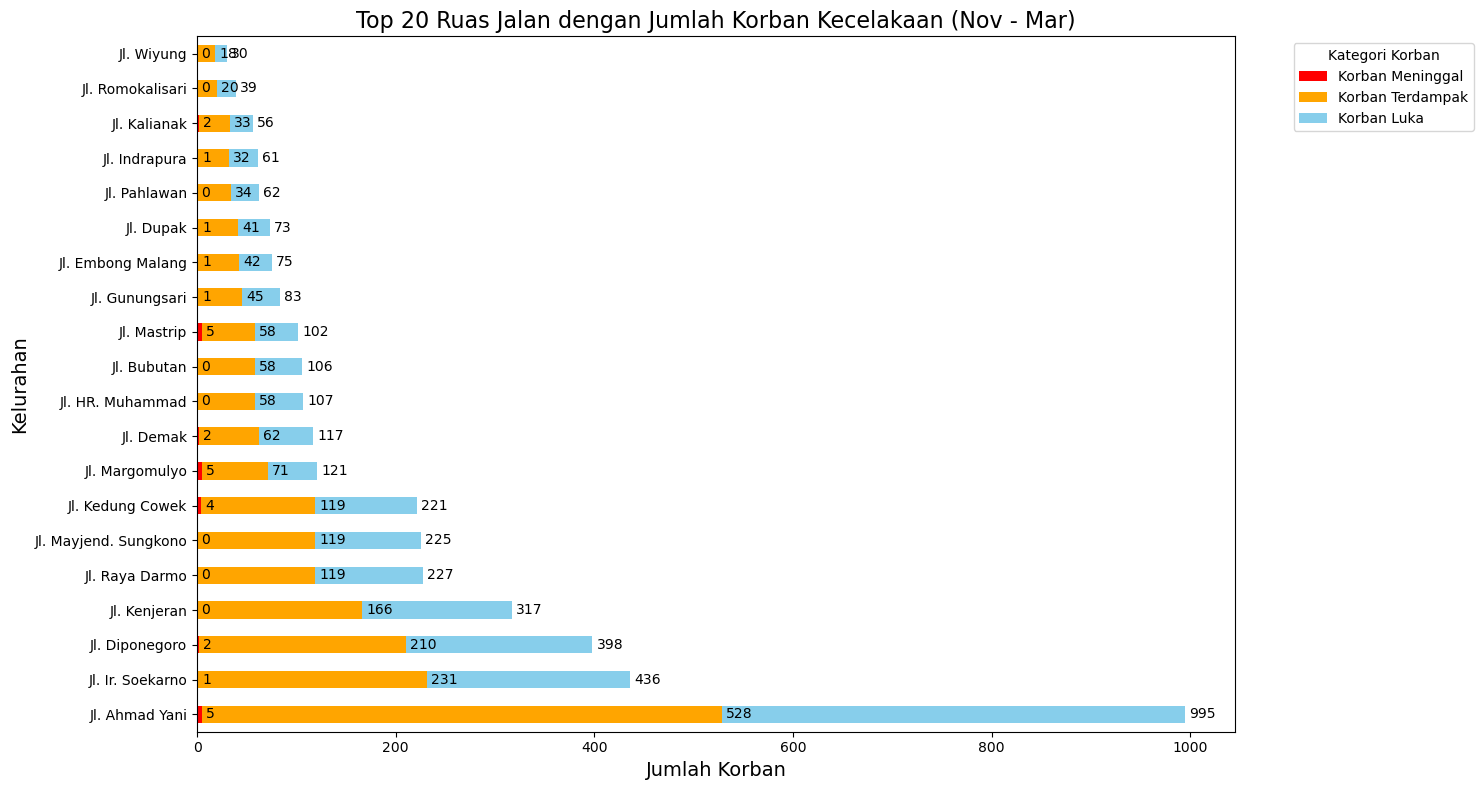

In [13]:
# Filter data untuk kejadian 'kecelakaan'
df_kecelakaan = df_filtered[df_filtered['JENIS KEJADIAN'].str.lower() == 'kecelakaan']

# Kelompokkan data berdasarkan 'KELURAHAN' dan hitung total korban
df_grouped = df_kecelakaan.groupby('RUAS JALAN').agg({
    'KORBAN MENINGGAL': 'sum',
    'KORBAN TERDAMPAK': 'sum',
    'KORBAN LUKA': 'sum'
}).reset_index()

# Tambahkan kolom 'TOTAL KORBAN' untuk sort
df_grouped['TOTAL KORBAN'] = (
    df_grouped['KORBAN MENINGGAL'].astype(float).fillna(0) +  # Pastikan semua kolom adalah float
    df_grouped['KORBAN TERDAMPAK'].astype(float).fillna(0) +
    df_grouped['KORBAN LUKA'].astype(float).fillna(0)
)

# Urutkan data berdasarkan 'TOTAL KORBAN' dan ambil 20 teratas
df_top20 = df_grouped.sort_values(by='TOTAL KORBAN', ascending=False).head(20)

# Plot bar chart horizontal untuk 20 kelurahan teratas
ax = df_top20.set_index('RUAS JALAN').drop(columns='TOTAL KORBAN').plot(
    kind='barh',
    figsize=(15, 8),
    stacked=True,
    color=['red', 'orange', 'skyblue'] 
)

# Tambahkan label angka di atas setiap bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, color='black', padding=3)

# Tambahkan judul dan label
plt.title('Top 20 Ruas Jalan dengan Jumlah Korban Kecelakaan (Nov - Mar)', fontsize=16)
plt.xlabel('Jumlah Korban', fontsize=14)
plt.ylabel('Kelurahan', fontsize=14)
plt.legend(title='Kategori Korban', labels=['Korban Meninggal', 'Korban Terdampak', 'Korban Luka'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Sesuaikan layout agar rapi
plt.tight_layout()

# Tampilkan plot
plt.show()

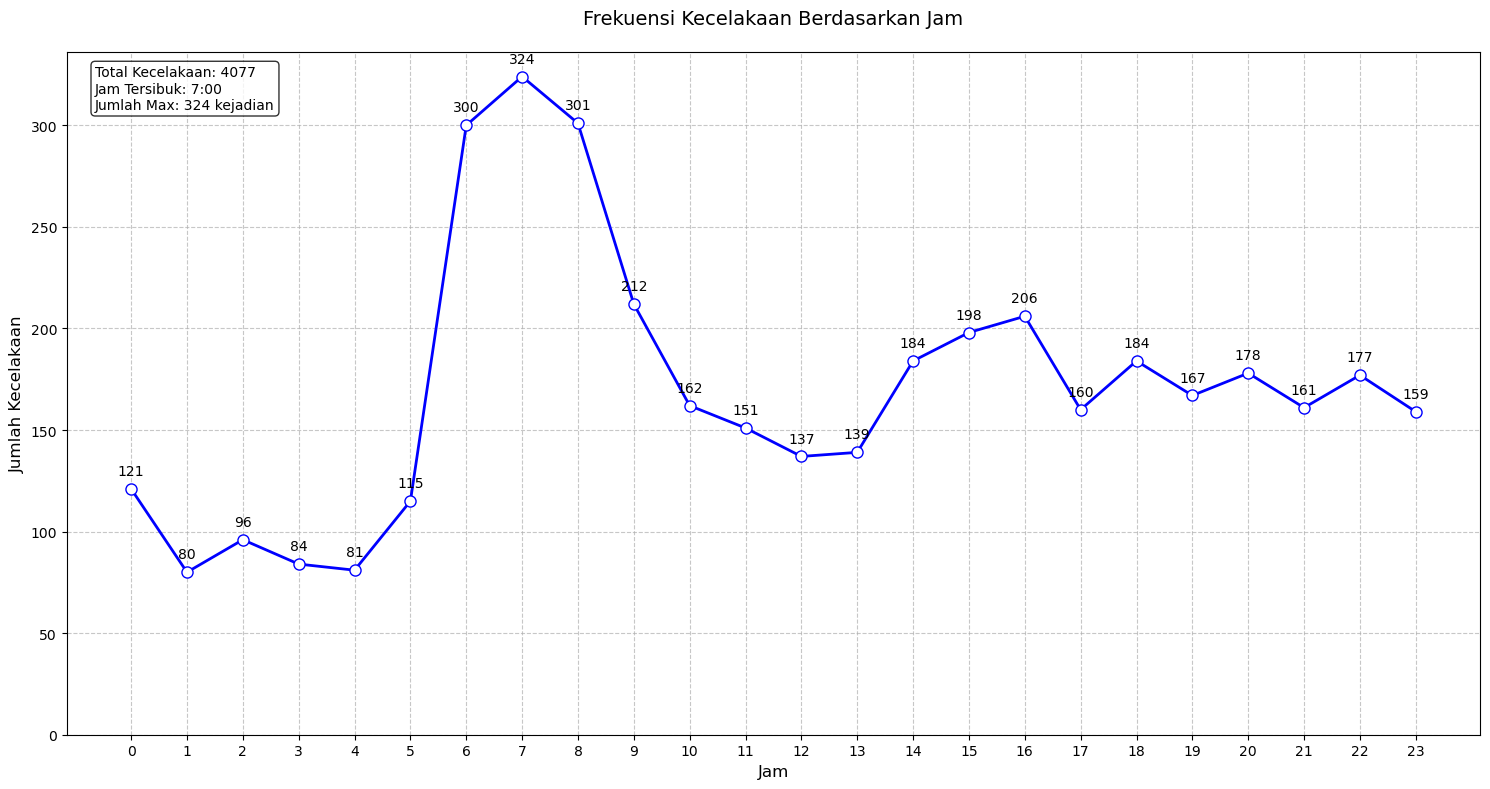


Analisis Waktu Kecelakaan:
Total kecelakaan: 4077
Jam dengan kecelakaan terbanyak: 7:00
Jumlah maksimum kecelakaan dalam 1 jam: 324
Rata-rata kecelakaan per jam: 169.88

Distribusi Kecelakaan per Periode:
Pagi (05:00-10:59): 1414 kejadian (34.7%)
Sore (15:00-18:59): 748 kejadian (18.3%)
Malam (19:00-22:59): 683 kejadian (16.8%)
Dini Hari (23:00-04:59): 621 kejadian (15.2%)
Siang (11:00-14:59): 611 kejadian (15.0%)


In [14]:
# Filter hanya kejadian kecelakaan
df_kecelakaan = df_filtered[df_filtered['JENIS KEJADIAN'] == 'Kecelakaan'].copy()

# Konversi OPEN TICKET ke datetime dengan format yang benar
df_kecelakaan['OPEN_TICKET_TIME'] = pd.to_datetime(df_kecelakaan['OPEN TICKET'], format='%H:%M:%S').dt.time
df_kecelakaan['JAM'] = pd.to_datetime(df_kecelakaan['OPEN TICKET'], format='%H:%M:%S').dt.hour

# Hitung frekuensi kecelakaan per jam
hourly_accidents = df_kecelakaan['JAM'].value_counts().sort_index()

# Buat line plot dengan styling yang lebih baik
plt.figure(figsize=(15, 8))
plt.plot(hourly_accidents.index, hourly_accidents.values, 
         marker='o', linewidth=2, color='blue', 
         markersize=8, markerfacecolor='white')

# Styling plot
plt.title('Frekuensi Kecelakaan Berdasarkan Jam', fontsize=14, pad=20)
plt.xlabel('Jam', fontsize=12)
plt.ylabel('Jumlah Kecelakaan', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(0, 24))

# Tambahkan label nilai pada setiap titik
for x, y in zip(hourly_accidents.index, hourly_accidents.values):
    plt.annotate(str(y), 
                (x, y), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=10)

# Atur batas sumbu y
plt.ylim(bottom=0)

# Tampilkan statistik pada plot
stats_text = f'Total Kecelakaan: {hourly_accidents.sum()}\n'
stats_text += f'Jam Tersibuk: {hourly_accidents.idxmax()}:00\n'
stats_text += f'Jumlah Max: {hourly_accidents.max()} kejadian'

plt.text(0.02, 0.98, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Atur layout dan tampilkan plot
plt.tight_layout()
plt.show()

# Cetak analisis tambahan
print("\nAnalisis Waktu Kecelakaan:")
print(f"Total kecelakaan: {hourly_accidents.sum()}")
print(f"Jam dengan kecelakaan terbanyak: {hourly_accidents.idxmax()}:00")
print(f"Jumlah maksimum kecelakaan dalam 1 jam: {hourly_accidents.max()}")
print(f"Rata-rata kecelakaan per jam: {hourly_accidents.mean():.2f}")

# Tampilkan distribusi per periode waktu
def get_time_period(hour):
    if 5 <= hour <= 10:
        return 'Pagi (05:00-10:59)'
    elif 11 <= hour <= 14:
        return 'Siang (11:00-14:59)'
    elif 15 <= hour <= 18:
        return 'Sore (15:00-18:59)'
    elif 19 <= hour <= 22:
        return 'Malam (19:00-22:59)'
    else:
        return 'Dini Hari (23:00-04:59)'

df_kecelakaan['Periode'] = df_kecelakaan['JAM'].apply(get_time_period)
periode_accidents = df_kecelakaan['Periode'].value_counts()

print("\nDistribusi Kecelakaan per Periode:")
for periode, jumlah in periode_accidents.items():
    print(f"{periode}: {jumlah} kejadian ({(jumlah/len(df_kecelakaan)*100):.1f}%)")

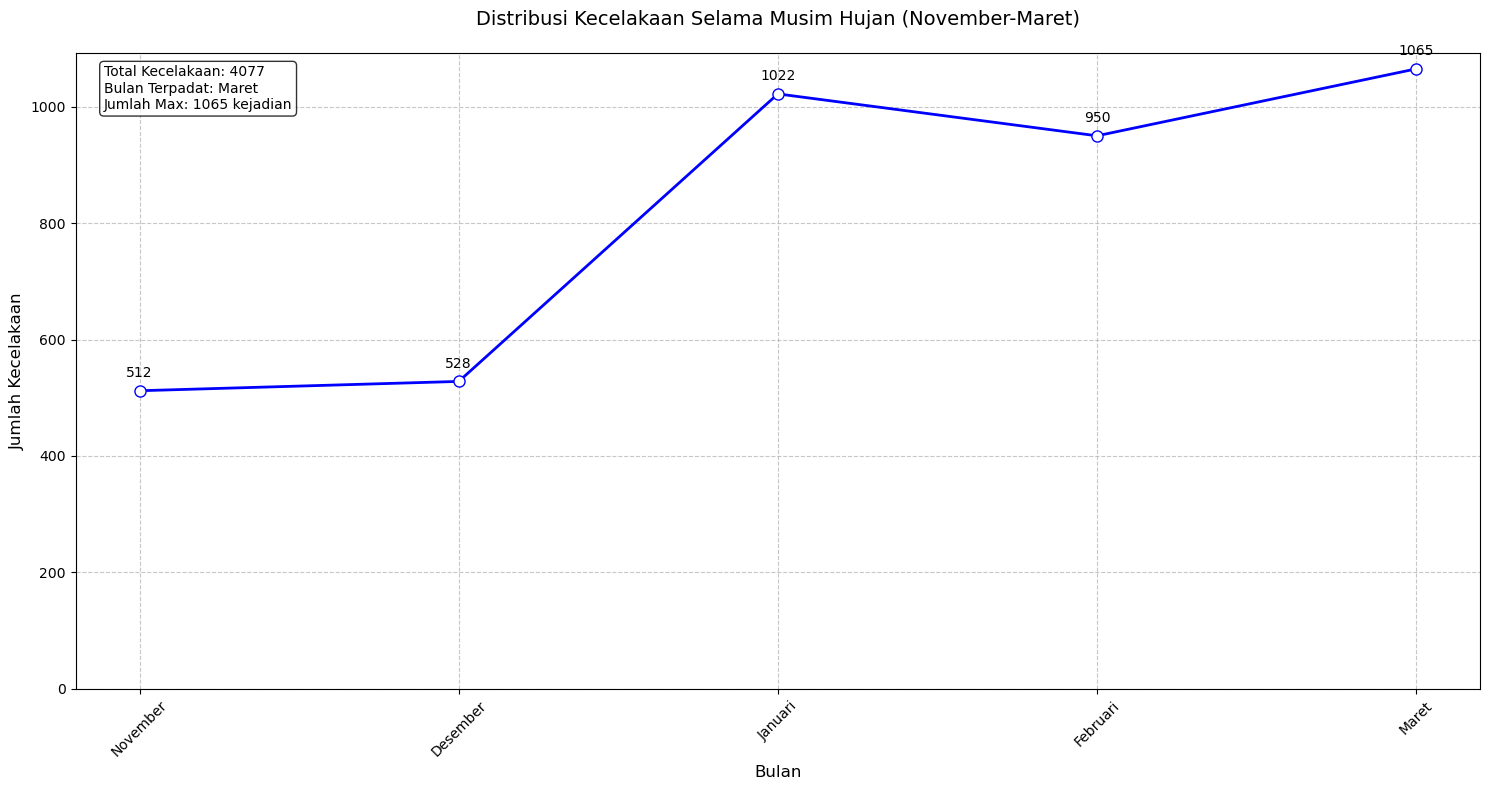


Analisis Kecelakaan Musim Hujan:
Total kecelakaan: 4077
Rata-rata kecelakaan per bulan: 815.40

Distribusi per bulan:
November: 512 kejadian (12.6%)
Desember: 528 kejadian (13.0%)
Januari: 1022 kejadian (25.1%)
Februari: 950 kejadian (23.3%)
Maret: 1065 kejadian (26.1%)

Analisis Trend:
Perubahan dari awal (November) ke akhir musim (Maret): 108.0%
Bulan dengan kecelakaan tertinggi: Maret
Bulan dengan kecelakaan terendah: November


In [15]:
# Filter data kecelakaan
df_kecelakaan = df_filtered[df_filtered['JENIS KEJADIAN'] == 'Kecelakaan'].copy()

# Tambahkan kolom bulan
df_kecelakaan['BULAN'] = df_kecelakaan['TANGGAL'].dt.month
df_kecelakaan['NAMA_BULAN'] = df_kecelakaan['TANGGAL'].dt.strftime('%B')  # Nama bulan lengkap

# Hitung jumlah kecelakaan per bulan
monthly_accidents = df_kecelakaan['BULAN'].value_counts().sort_index()

# Urutkan bulan sesuai musim hujan (November-Maret)
bulan_order = [11, 12, 1, 2, 3]
monthly_accidents = monthly_accidents.reindex(bulan_order)

# Dictionary untuk nama bulan dalam Bahasa Indonesia
nama_bulan = {
    11: 'November',
    12: 'Desember',
    1: 'Januari',
    2: 'Februari',
    3: 'Maret'
}

# Buat line plot
plt.figure(figsize=(15, 8))
plt.plot(range(len(monthly_accidents)), monthly_accidents.values, 
         marker='o', linewidth=2, color='blue', 
         markersize=8, markerfacecolor='white')

# Styling plot
plt.title('Distribusi Kecelakaan Selama Musim Hujan (November-Maret)', fontsize=14, pad=20)
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Jumlah Kecelakaan', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-ticks dengan nama bulan
plt.xticks(range(len(monthly_accidents)), 
           [nama_bulan[bulan] for bulan in bulan_order],
           rotation=45)

# Tambahkan label nilai pada setiap titik
for i, v in enumerate(monthly_accidents.values):
    plt.annotate(str(v), 
                (i, v), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=10)

# Atur batas sumbu y
plt.ylim(bottom=0)

# Tambahkan statistik pada plot
stats_text = f'Total Kecelakaan: {monthly_accidents.sum()}\n'
stats_text += f'Bulan Terpadat: {nama_bulan[monthly_accidents.idxmax()]}\n'
stats_text += f'Jumlah Max: {monthly_accidents.max()} kejadian'

plt.text(0.02, 0.98, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Atur layout dan tampilkan plot
plt.tight_layout()
plt.show()

# Cetak analisis tambahan
print("\nAnalisis Kecelakaan Musim Hujan:")
print(f"Total kecelakaan: {monthly_accidents.sum()}")
print(f"Rata-rata kecelakaan per bulan: {monthly_accidents.mean():.2f}")
print("\nDistribusi per bulan:")
for bulan in bulan_order:
    jumlah = monthly_accidents[bulan]
    print(f"{nama_bulan[bulan]}: {jumlah} kejadian ({(jumlah/monthly_accidents.sum()*100):.1f}%)")

# Hitung statistik trend
awal_musim = monthly_accidents[11]  # November
akhir_musim = monthly_accidents[3]   # Maret
perubahan = ((akhir_musim - awal_musim) / awal_musim * 100)

print(f"\nAnalisis Trend:")
print(f"Perubahan dari awal (November) ke akhir musim (Maret): {perubahan:.1f}%")
print(f"Bulan dengan kecelakaan tertinggi: {nama_bulan[monthly_accidents.idxmax()]}")
print(f"Bulan dengan kecelakaan terendah: {nama_bulan[monthly_accidents.idxmin()]}")

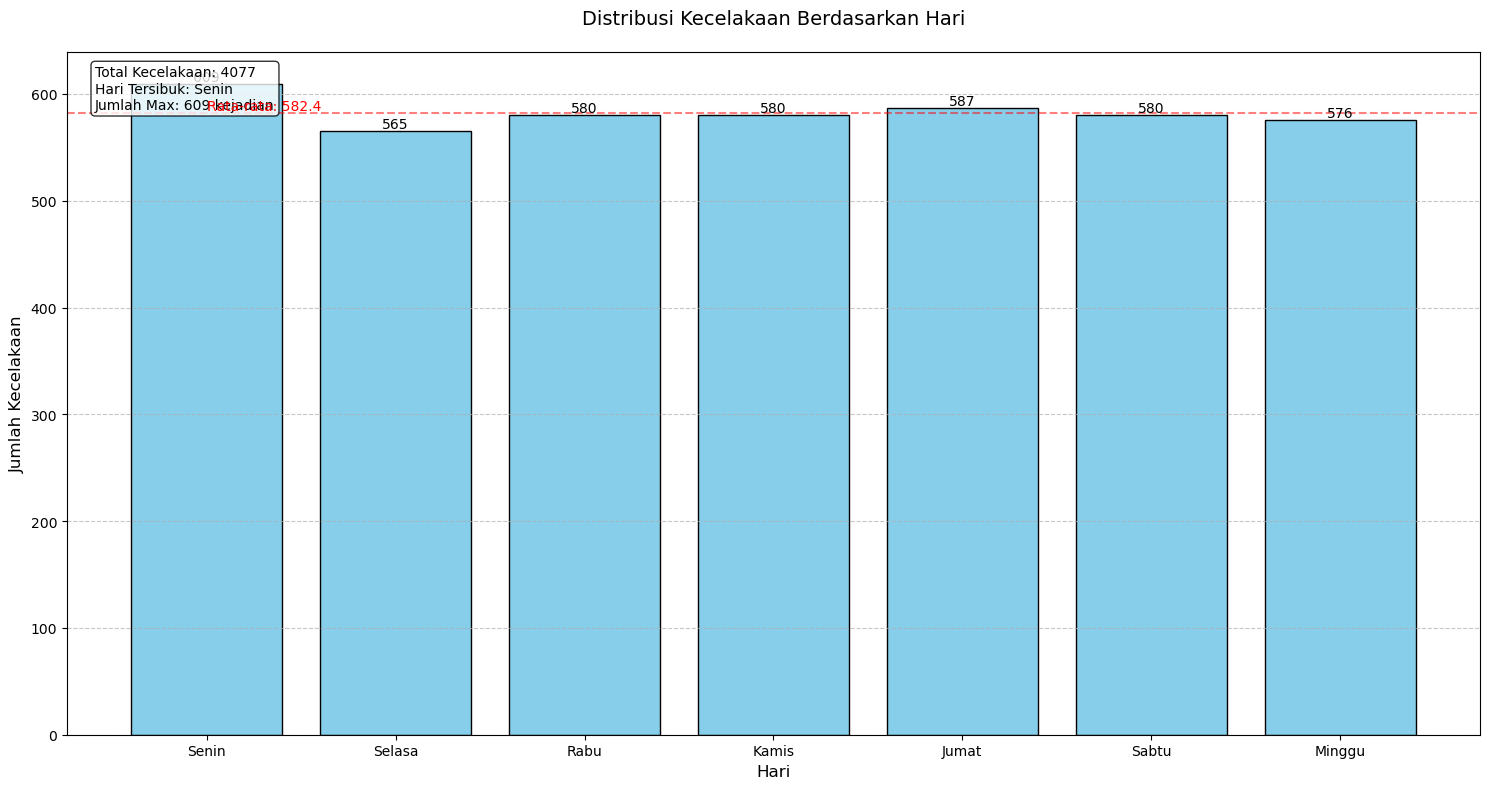


Analisis Kecelakaan per Hari:
Total kecelakaan: 4077
Rata-rata kecelakaan per hari: 582.43

Distribusi per hari:
Senin: 609 kejadian (14.9%)
Selasa: 565 kejadian (13.9%)
Rabu: 580 kejadian (14.2%)
Kamis: 580 kejadian (14.2%)
Jumat: 587 kejadian (14.4%)
Sabtu: 580 kejadian (14.2%)
Minggu: 576 kejadian (14.1%)

Analisis Weekday vs Weekend:
Total kecelakaan hari kerja (Senin-Jumat): 2921 (71.6%)
Total kecelakaan akhir pekan (Sabtu-Minggu): 1156 (28.4%)
Rata-rata kecelakaan hari kerja: 584.20
Rata-rata kecelakaan akhir pekan: 578.00


In [16]:
# Filter data kecelakaan
df_kecelakaan = df_filtered[df_filtered['JENIS KEJADIAN'] == 'Kecelakaan'].copy()

# Tambahkan kolom hari
df_kecelakaan['HARI'] = df_kecelakaan['TANGGAL'].dt.day_name()

# Dictionary untuk nama hari dalam Bahasa Indonesia
nama_hari = {
    'Monday': 'Senin',
    'Tuesday': 'Selasa',
    'Wednesday': 'Rabu',
    'Thursday': 'Kamis',
    'Friday': 'Jumat',
    'Saturday': 'Sabtu',
    'Sunday': 'Minggu'
}

# Terjemahkan nama hari ke Bahasa Indonesia
df_kecelakaan['HARI_ID'] = df_kecelakaan['HARI'].map(nama_hari)

# Urutkan hari sesuai urutan umum (Senin-Minggu)
urutan_hari = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu']
daily_accidents = df_kecelakaan['HARI_ID'].value_counts().reindex(urutan_hari)

# Buat bar plot
plt.figure(figsize=(15, 8))
bars = plt.bar(urutan_hari, daily_accidents.values, color='skyblue', edgecolor='black')

# Styling plot
plt.title('Distribusi Kecelakaan Berdasarkan Hari', fontsize=14, pad=20)
plt.xlabel('Hari', fontsize=12)
plt.ylabel('Jumlah Kecelakaan', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Tambahkan label nilai pada setiap bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Atur batas sumbu y
plt.ylim(bottom=0)

# Tambahkan statistik pada plot
stats_text = f'Total Kecelakaan: {daily_accidents.sum()}\n'
stats_text += f'Hari Tersibuk: {daily_accidents.idxmax()}\n'
stats_text += f'Jumlah Max: {daily_accidents.max()} kejadian'

plt.text(0.02, 0.98, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Tambahkan rata-rata harian sebagai garis horizontal
rata_rata = daily_accidents.mean()
plt.axhline(y=rata_rata, color='red', linestyle='--', alpha=0.5)
plt.text(0, rata_rata, f'Rata-rata: {rata_rata:.1f}', 
         verticalalignment='bottom', horizontalalignment='left',
         color='red')

# Atur layout dan tampilkan plot
plt.tight_layout()
plt.show()

# Cetak analisis tambahan
print("\nAnalisis Kecelakaan per Hari:")
print(f"Total kecelakaan: {daily_accidents.sum()}")
print(f"Rata-rata kecelakaan per hari: {daily_accidents.mean():.2f}")
print("\nDistribusi per hari:")
for hari in urutan_hari:
    jumlah = daily_accidents[hari]
    print(f"{hari}: {jumlah} kejadian ({(jumlah/daily_accidents.sum()*100):.1f}%)")

# Analisis weekend vs weekday
weekday = daily_accidents[:'Jumat'].sum()
weekend = daily_accidents['Sabtu':].sum()

print("\nAnalisis Weekday vs Weekend:")
print(f"Total kecelakaan hari kerja (Senin-Jumat): {weekday} ({(weekday/daily_accidents.sum()*100):.1f}%)")
print(f"Total kecelakaan akhir pekan (Sabtu-Minggu): {weekend} ({(weekend/daily_accidents.sum()*100):.1f}%)")
print(f"Rata-rata kecelakaan hari kerja: {(weekday/5):.2f}")
print(f"Rata-rata kecelakaan akhir pekan: {(weekend/2):.2f}")

## 2. Statistika Deskriptif Jenis Kejadian DARURAT MEDIS

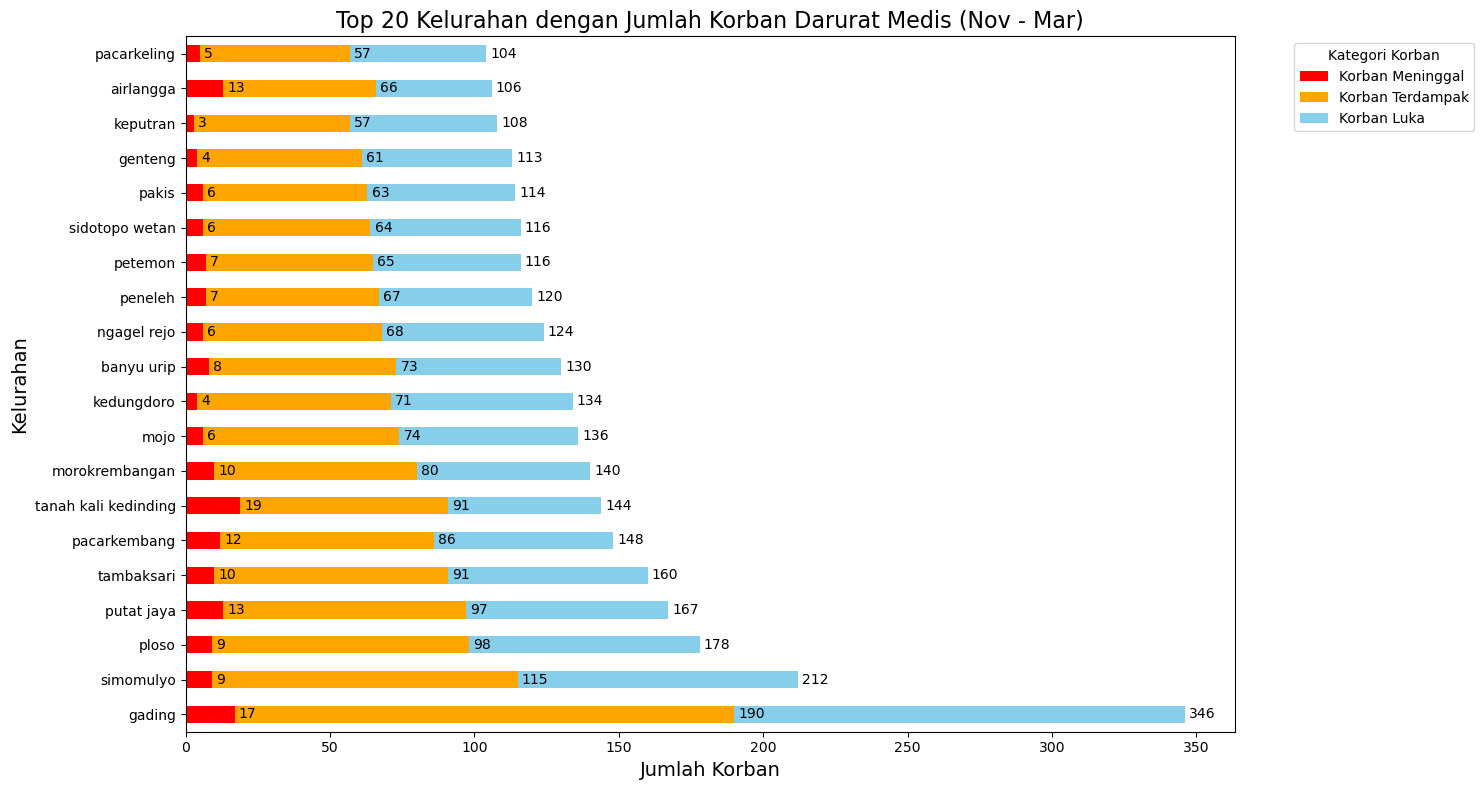

In [17]:
# Filter data untuk kejadian 'kecelakaan'
df_DM = df_filtered[df_filtered['JENIS KEJADIAN'].str.lower() == 'darurat medis']

# Kelompokkan data berdasarkan 'KELURAHAN' dan hitung total korban
df_grouped_DM = df_DM.groupby('KELURAHAN').agg({
    'KORBAN MENINGGAL': 'sum',
    'KORBAN TERDAMPAK': 'sum',
    'KORBAN LUKA': 'sum'
}).reset_index()

# Tambahkan kolom 'TOTAL KORBAN' untuk sort
df_grouped_DM['TOTAL KORBAN'] = (
    df_grouped_DM['KORBAN MENINGGAL'].astype(float).fillna(0) +  # Pastikan semua kolom adalah float
    df_grouped_DM['KORBAN TERDAMPAK'].astype(float).fillna(0) +
    df_grouped_DM['KORBAN LUKA'].astype(float).fillna(0)
)

# Urutkan data berdasarkan 'TOTAL KORBAN' dan ambil 20 teratas
df_top20_DM = df_grouped_DM.sort_values(by='TOTAL KORBAN', ascending=False).head(20)

# Plot bar chart horizontal untuk 20 kelurahan teratas
ax = df_top20_DM.set_index('KELURAHAN').drop(columns='TOTAL KORBAN').plot(
    kind='barh',
    figsize=(15, 8),
    stacked=True,
    color=['red', 'orange', 'skyblue']  # Mengubah warna sesuai permintaan
)

# Tambahkan label angka di atas setiap bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, color='black', padding=3)

# Tambahkan judul dan label
plt.title('Top 20 Kelurahan dengan Jumlah Korban Darurat Medis (Nov - Mar)', fontsize=16)
plt.xlabel('Jumlah Korban', fontsize=14)
plt.ylabel('Kelurahan', fontsize=14)
plt.legend(title='Kategori Korban', labels=['Korban Meninggal', 'Korban Terdampak', 'Korban Luka'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Sesuaikan layout agar rapi
plt.tight_layout()

# Tampilkan plot
plt.show()

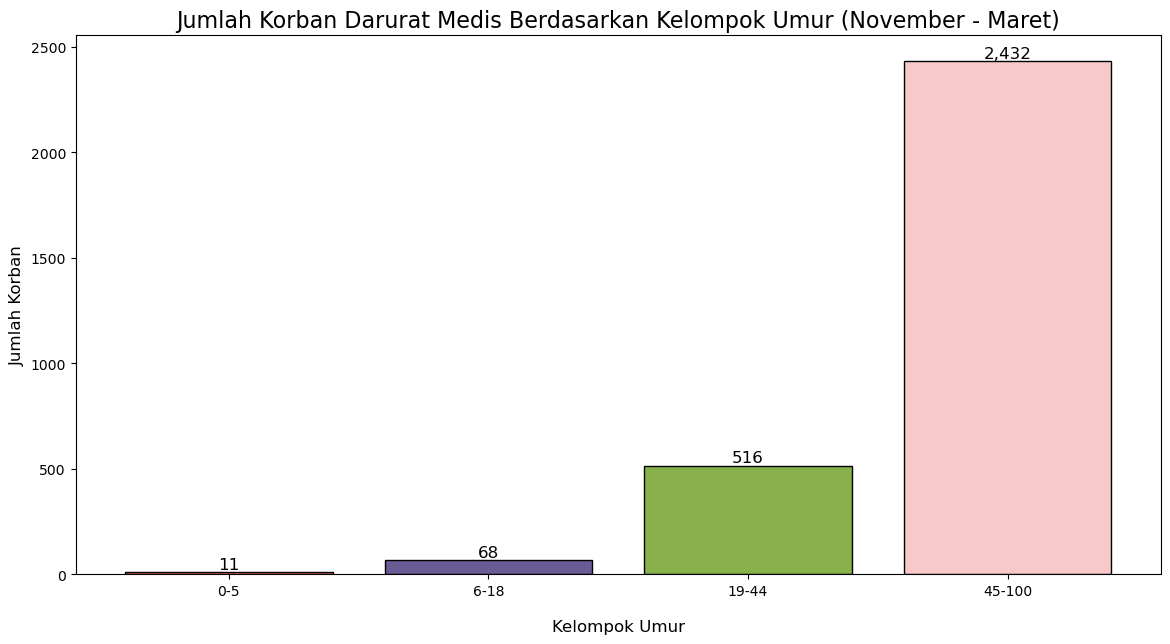

In [18]:
# Hitung total korban berdasarkan kelompok umur
korban_umur = {
    '0-5': df_DM['0-5'].sum(),
    '6-18': df_DM['6-18'].sum(),
    '19-44': df_DM['19-44'].sum(),
    '45-100': df_DM['45-100'].sum()
}

# Data untuk grafik
kategori_umur = list(korban_umur.keys())
jumlah_korban = list(korban_umur.values())

# Palet warna yang estetis
colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9']  # Peach, Lavender, Green, Pink

# Plot bar chart
plt.figure(figsize=(14, 7))
bars = plt.bar(kategori_umur, jumlah_korban, color=colors, edgecolor='black')

# Tambahkan angka di atas setiap bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,  # Posisi X
             bar.get_height(),                  # Posisi Y
             f'{bar.get_height():,.0f}',        # Format angka
             ha='center', va='bottom', fontsize=12)  # Posisi teks

# Tambahkan judul dan label
plt.title('Jumlah Korban Darurat Medis Berdasarkan Kelompok Umur (November - Maret)', fontsize=16)
plt.xlabel('Kelompok Umur', fontsize=12, labelpad=15)
plt.ylabel('Jumlah Korban', fontsize=12)

# Tampilkan plot
plt.show()

C:\Users\Selayanti\AppData\Local\Temp\ipykernel_14632\2061447349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DM['TINDAK LANJUT DM'] = df_DM['TINDAK LANJUT DM'].str.lower()  # Mengubah semua huruf menjadi kecil
C:\Users\Selayanti\AppData\Local\Temp\ipykernel_14632\2061447349.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DM['TINDAK LANJUT DM'] = df_DM['TINDAK LANJUT DM'].replace(mapping)


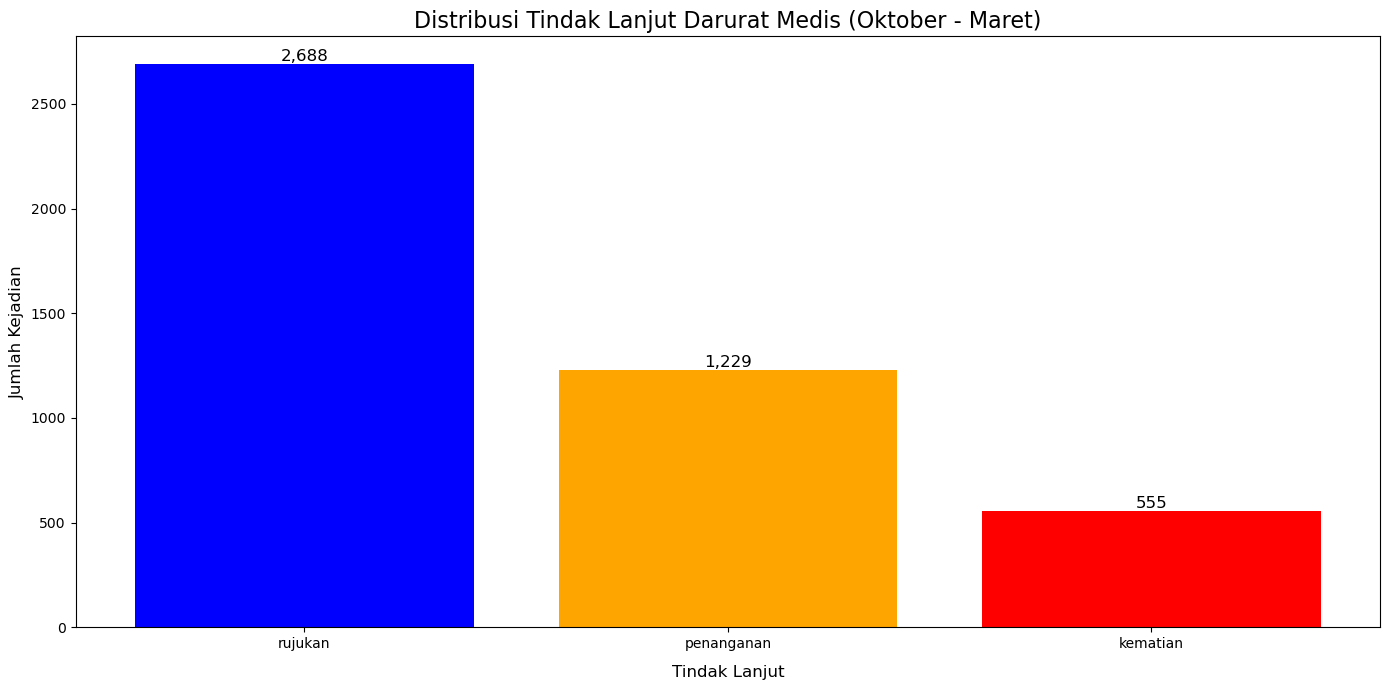

In [19]:
# Normalisasi kolom 'TINDAK LANJUT DM' untuk menggabungkan kategori
df_DM['TINDAK LANJUT DM'] = df_DM['TINDAK LANJUT DM'].str.lower()  # Mengubah semua huruf menjadi kecil

# Buat mapping untuk menggabungkan kategori yang serupa
mapping = {
    'rujukan': 'rujukan',
    'kematian': 'kematian',
    'penanganan': 'penanganan'
}

# Terapkan mapping
df_DM['TINDAK LANJUT DM'] = df_DM['TINDAK LANJUT DM'].replace(mapping)

# Hitung frekuensi setiap kategori pada kolom 'TINDAK LANJUT DM'
tindak_lanjut_counts = df_DM['TINDAK LANJUT DM'].value_counts()

# Data untuk grafik
kategori_tindak_lanjut = tindak_lanjut_counts.index
jumlah_tindak_lanjut = tindak_lanjut_counts.values

# Palet warna yang harmonis
colors = ['blue', 'orange', 'red']  # Biru, Hijau, Merah

# Plot bar chart
plt.figure(figsize=(14, 7))
bars = plt.bar(kategori_tindak_lanjut, jumlah_tindak_lanjut, color=colors)

# Tambahkan angka di atas setiap bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,  # Posisi X
             bar.get_height(),                  # Posisi Y
             f'{bar.get_height():,.0f}',        # Format angka
             ha='center', va='bottom', fontsize=12)  # Posisi teks

# Tambahkan judul dan label
plt.title('Distribusi Tindak Lanjut Darurat Medis (Oktober - Maret)', fontsize=16)
plt.xlabel('Tindak Lanjut', fontsize=12, labelpad=10)
plt.ylabel('Jumlah Kejadian', fontsize=12)

# Rotasi label jika diperlukan (untuk teks panjang)
plt.xticks(rotation=0)

# Tampilkan plot
plt.tight_layout()
plt.show()

## 3. Statistika Deskriptif Jenis Kejadian KEBAKARAN

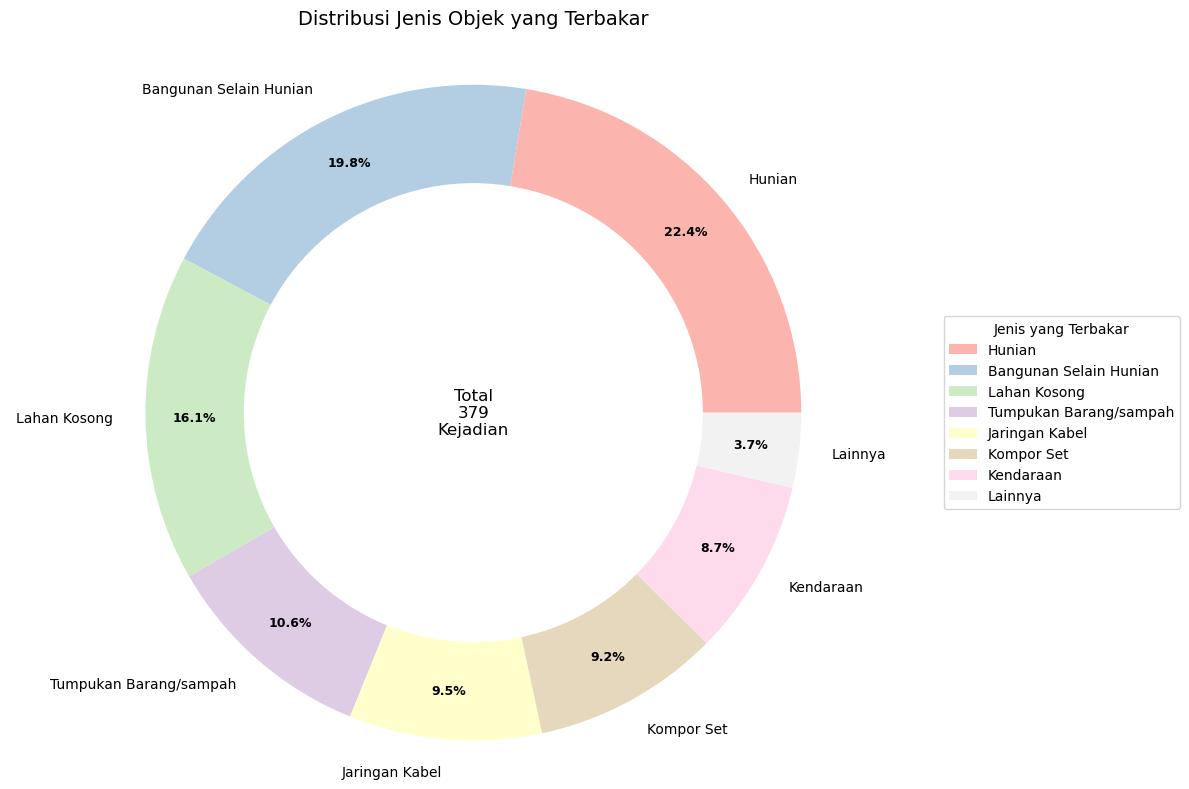


Analisis Detail Kebakaran:
Total kejadian kebakaran: 379

Distribusi jenis yang terbakar:
Hunian: 85 kejadian (22.4%)
Bangunan Selain Hunian: 75 kejadian (19.8%)
Lahan Kosong: 61 kejadian (16.1%)
Tumpukan Barang/sampah: 40 kejadian (10.6%)
Jaringan Kabel: 36 kejadian (9.5%)
Kompor Set: 35 kejadian (9.2%)
Kendaraan: 33 kejadian (8.7%)
Lainnya: 14 kejadian (3.7%)

Analisis Tambahan:
Jenis terbanyak: Hunian (85 kejadian)
Rata-rata kejadian per jenis: 47.4

Catatan: 3 kategori kecil digabungkan ke dalam 'Lainnya'


In [20]:
# Filter data kebakaran
df_kebakaran = df_filtered[df_filtered['JENIS KEJADIAN'] == 'Kebakaran'].copy()

# Hitung frekuensi jenis yang terbakar
# Hapus data kosong dan strip whitespace
df_kebakaran['YANG TERBAKAR'] = df_kebakaran['YANG TERBAKAR'].str.strip()
fire_types = df_kebakaran['YANG TERBAKAR'].value_counts()

# Gabungkan kategori kecil (< 5% dari total) ke dalam "Lainnya"
threshold = len(df_kebakaran) * 0.05
small_categories = fire_types[fire_types < threshold]
if not small_categories.empty:
    fire_types = fire_types[fire_types >= threshold]
    fire_types['Lainnya'] = small_categories.sum()

# Buat figure dengan ukuran yang sesuai
plt.figure(figsize=(12, 8))

# Buat donut chart
colors = plt.cm.Pastel1(np.linspace(0, 1, len(fire_types)))
wedges, texts, autotexts = plt.pie(fire_types.values, 
                                  labels=fire_types.index,
                                  colors=colors,
                                  autopct='%1.1f%%',
                                  pctdistance=0.85,
                                  wedgeprops=dict(width=0.6))

# Styling autotexts
plt.setp(autotexts, size=9, weight="bold")
plt.setp(texts, size=10)

# Tambahkan judul
plt.title('Distribusi Jenis Objek yang Terbakar', pad=20, size=14)

# Tambahkan total kejadian di tengah donut
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Tambahkan teks total di tengah
plt.text(0, 0, f'Total\n{len(df_kebakaran)}\nKejadian', 
         ha='center', va='center', fontsize=12)

# Tambahkan legenda terpisah
plt.legend(wedges, fire_types.index,
          title="Jenis yang Terbakar",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.axis('equal')
plt.tight_layout()
plt.show()

# Cetak analisis detail
print("\nAnalisis Detail Kebakaran:")
print(f"Total kejadian kebakaran: {len(df_kebakaran)}")
print("\nDistribusi jenis yang terbakar:")
for jenis, jumlah in fire_types.items():
    percentage = (jumlah/len(df_kebakaran)*100)
    print(f"{jenis}: {int(jumlah)} kejadian ({percentage:.1f}%)")

# Analisis tambahan
print("\nAnalisis Tambahan:")
print(f"Jenis terbanyak: {fire_types.index[0]} ({fire_types.values[0]} kejadian)")
print(f"Rata-rata kejadian per jenis: {fire_types.mean():.1f}")

# Hitung jumlah kategori asli vs yang ditampilkan
original_categories = df_kebakaran['YANG TERBAKAR'].nunique()
displayed_categories = len(fire_types)
if original_categories > displayed_categories:
    print(f"\nCatatan: {original_categories - displayed_categories} kategori kecil digabungkan ke dalam 'Lainnya'")

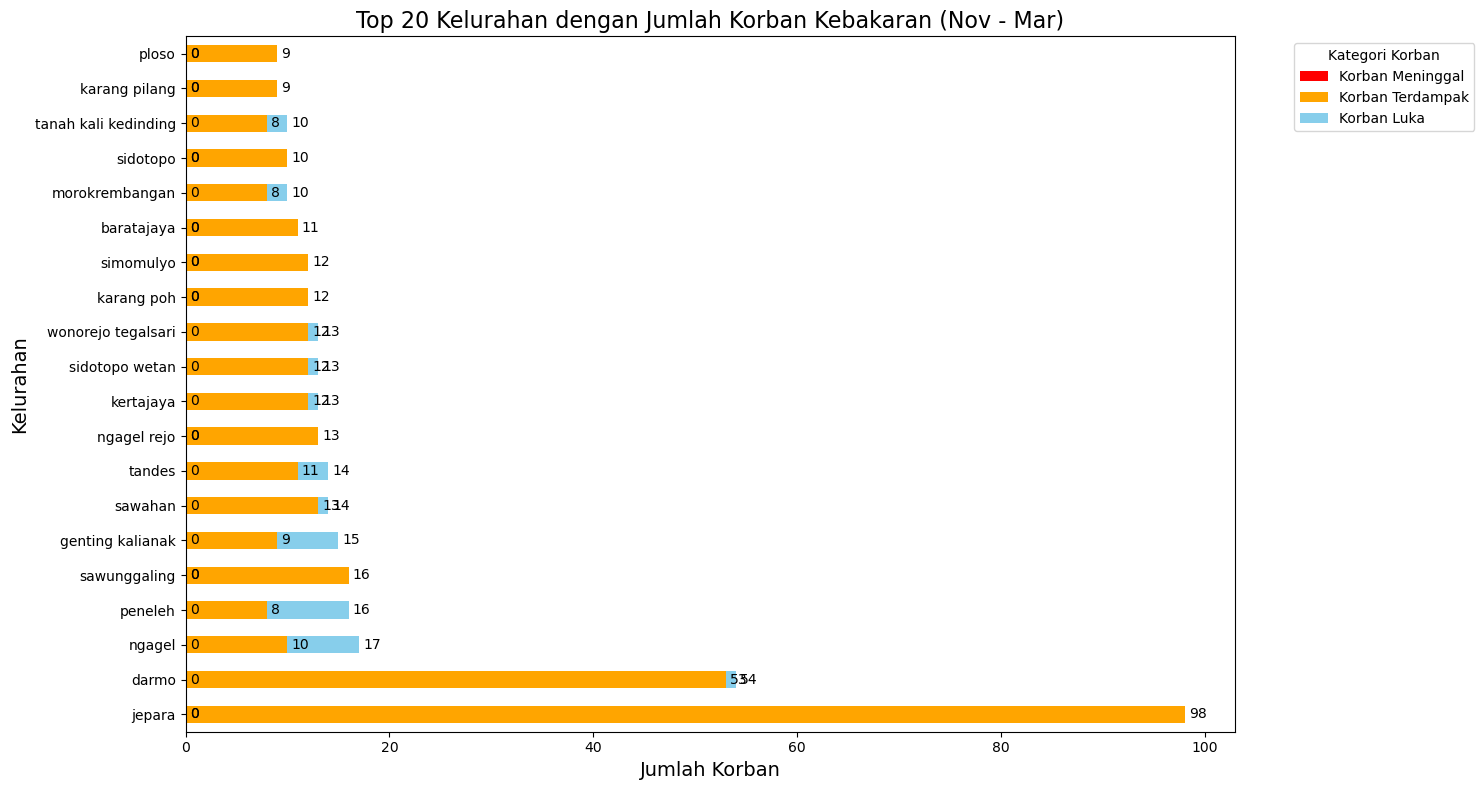

In [21]:
# Filter data untuk kejadian 'kecelakaan'
df_kbkrn = df_filtered[df_filtered['JENIS KEJADIAN'].str.lower() == 'kebakaran']

# Kelompokkan data berdasarkan 'KELURAHAN' dan hitung total korban
df_grouped_kbkrn = df_kbkrn.groupby('KELURAHAN').agg({
    'KORBAN MENINGGAL': 'sum',
    'KORBAN TERDAMPAK': 'sum',
    'KORBAN LUKA': 'sum'
}).reset_index()

# Tambahkan kolom 'TOTAL KORBAN' untuk sort
df_grouped_kbkrn['TOTAL KORBAN'] = (
    df_grouped_kbkrn['KORBAN MENINGGAL'].astype(float).fillna(0) +  # Pastikan semua kolom adalah float
    df_grouped_kbkrn['KORBAN TERDAMPAK'].astype(float).fillna(0) +
    df_grouped_kbkrn['KORBAN LUKA'].astype(float).fillna(0)
)

# Urutkan data berdasarkan 'TOTAL KORBAN' dan ambil 20 teratas
df_top20_kbkrn = df_grouped_kbkrn.sort_values(by='TOTAL KORBAN', ascending=False).head(20)

# Plot bar chart horizontal untuk 20 kelurahan teratas
ax = df_top20_kbkrn.set_index('KELURAHAN').drop(columns='TOTAL KORBAN').plot(
    kind='barh',
    figsize=(15, 8),
    stacked=True,
    color=['red', 'orange', 'skyblue']  # Mengubah warna sesuai permintaan
)

# Tambahkan label angka di atas setiap bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, color='black', padding=3)

# Tambahkan judul dan label
plt.title('Top 20 Kelurahan dengan Jumlah Korban Kebakaran (Nov - Mar)', fontsize=16)
plt.xlabel('Jumlah Korban', fontsize=14)
plt.ylabel('Kelurahan', fontsize=14)
plt.legend(title='Kategori Korban', labels=['Korban Meninggal', 'Korban Terdampak', 'Korban Luka'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Sesuaikan layout agar rapi
plt.tight_layout()

# Tampilkan plot
plt.show()

## 4. Statistika Deskriptif Jenis Kejadian POHON TUMBANG

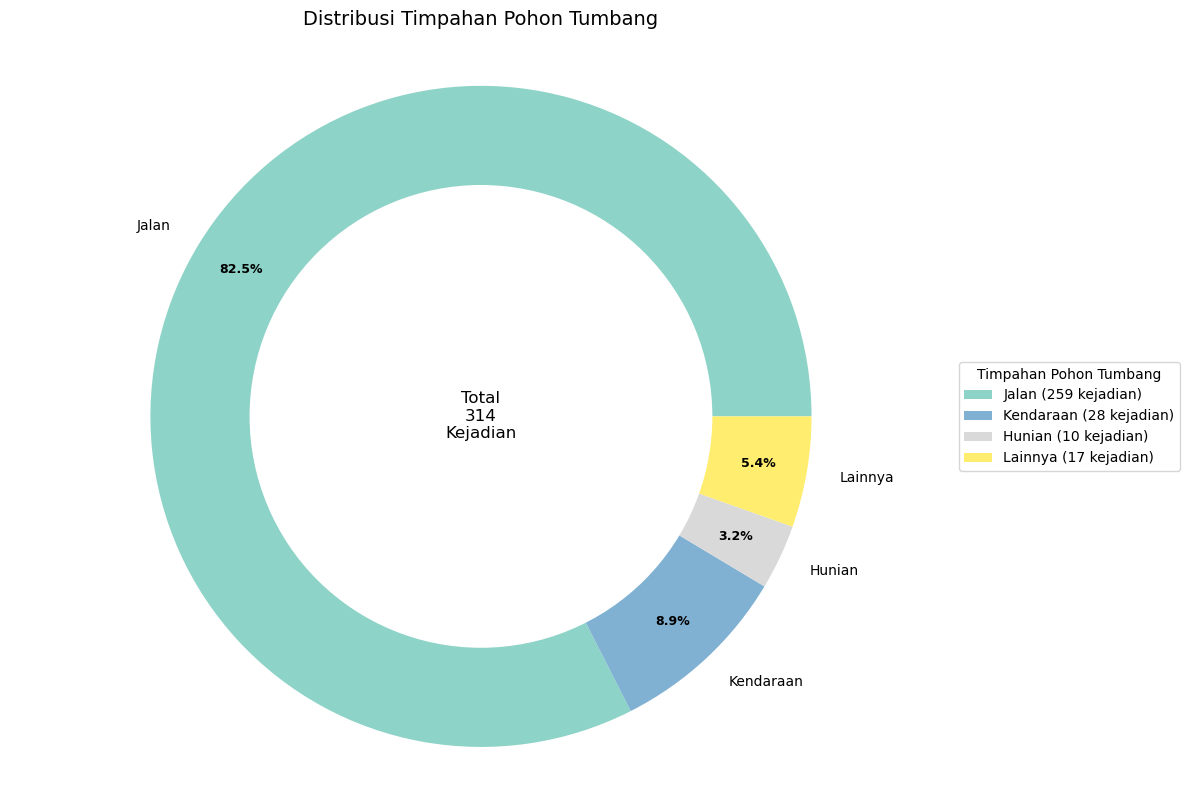


Analisis Detail Timpahan Pohon Tumbang:
Total kejadian pohon tumbang: 314

Distribusi timpahan pohon tumbang:
Jalan: 259 kejadian (82.5%)
Kendaraan: 28 kejadian (8.9%)
Hunian: 10 kejadian (3.2%)
Lainnya: 17 kejadian (5.4%)

Analisis Tambahan:
Timpahan terbanyak: Jalan (259 kejadian)
Rata-rata kejadian per jenis timpahan: 78.5

Dampak pada infrastruktur: 259 kejadian (82.5%)

Catatan: 2 kategori kecil digabungkan ke dalam 'Lainnya' (kurang dari 9 kejadian)


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter data pohon tumbang
df_pohon = df_filtered[df_filtered['JENIS KEJADIAN'] == 'Pohon Tumbang'].copy()

# Hitung frekuensi timpahan pohon tumbang
# Hapus data kosong dan strip whitespace
df_pohon['TIMPAHAN P. TUMBANG'] = df_pohon['TIMPAHAN P. TUMBANG'].str.strip()
tree_impact = df_pohon['TIMPAHAN P. TUMBANG'].value_counts()

# Gabungkan kategori kecil (< 3% dari total) ke dalam "Lainnya"
threshold = len(df_pohon) * 0.03
small_categories = tree_impact[tree_impact < threshold]
if not small_categories.empty:
    tree_impact = tree_impact[tree_impact >= threshold]
    tree_impact['Lainnya'] = small_categories.sum()

# Buat figure dengan ukuran yang sesuai
plt.figure(figsize=(12, 8))

# Buat donut chart dengan warna yang lebih menarik
colors = plt.cm.Set3(np.linspace(0, 1, len(tree_impact)))
wedges, texts, autotexts = plt.pie(tree_impact.values, 
                                  labels=tree_impact.index,
                                  colors=colors,
                                  autopct='%1.1f%%',
                                  pctdistance=0.85,
                                  wedgeprops=dict(width=0.6))

# Styling autotexts
plt.setp(autotexts, size=9, weight="bold")
plt.setp(texts, size=10)

# Tambahkan judul
plt.title('Distribusi Timpahan Pohon Tumbang', pad=20, size=14)

# Tambahkan total kejadian di tengah donut
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Tambahkan teks total di tengah
plt.text(0, 0, f'Total\n{len(df_pohon)}\nKejadian', 
         ha='center', va='center', fontsize=12)

# Tambahkan legenda terpisah dengan penjelasan lebih detail
plt.legend(wedges, [f"{idx} ({int(val)} kejadian)" 
                   for idx, val in tree_impact.items()],
          title="Timpahan Pohon Tumbang",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.axis('equal')
plt.tight_layout()
plt.show()

# Cetak analisis detail
print("\nAnalisis Detail Timpahan Pohon Tumbang:")
print(f"Total kejadian pohon tumbang: {len(df_pohon)}")
print("\nDistribusi timpahan pohon tumbang:")
for timpahan, jumlah in tree_impact.items():
    percentage = (jumlah/len(df_pohon)*100)
    print(f"{timpahan}: {int(jumlah)} kejadian ({percentage:.1f}%)")

# Analisis tambahan
print("\nAnalisis Tambahan:")
print(f"Timpahan terbanyak: {tree_impact.index[0]} ({tree_impact.values[0]} kejadian)")
print(f"Rata-rata kejadian per jenis timpahan: {tree_impact.mean():.1f}")

# Hitung persentase dampak pada infrastruktur
infrastruktur = ['Jalan', 'Rumah', 'Kabel', 'Bangunan']
infrastruktur_impact = sum(tree_impact[idx] for idx in tree_impact.index 
                          if any(infra in idx for infra in infrastruktur))
print(f"\nDampak pada infrastruktur: {infrastruktur_impact} kejadian "
      f"({(infrastruktur_impact/len(df_pohon)*100):.1f}%)")

# Hitung jumlah kategori asli vs yang ditampilkan
original_categories = df_pohon['TIMPAHAN P. TUMBANG'].nunique()
displayed_categories = len(tree_impact)
if original_categories > displayed_categories:
    print(f"\nCatatan: {original_categories - displayed_categories} kategori kecil "
          f"digabungkan ke dalam 'Lainnya' (kurang dari {threshold:.0f} kejadian)")

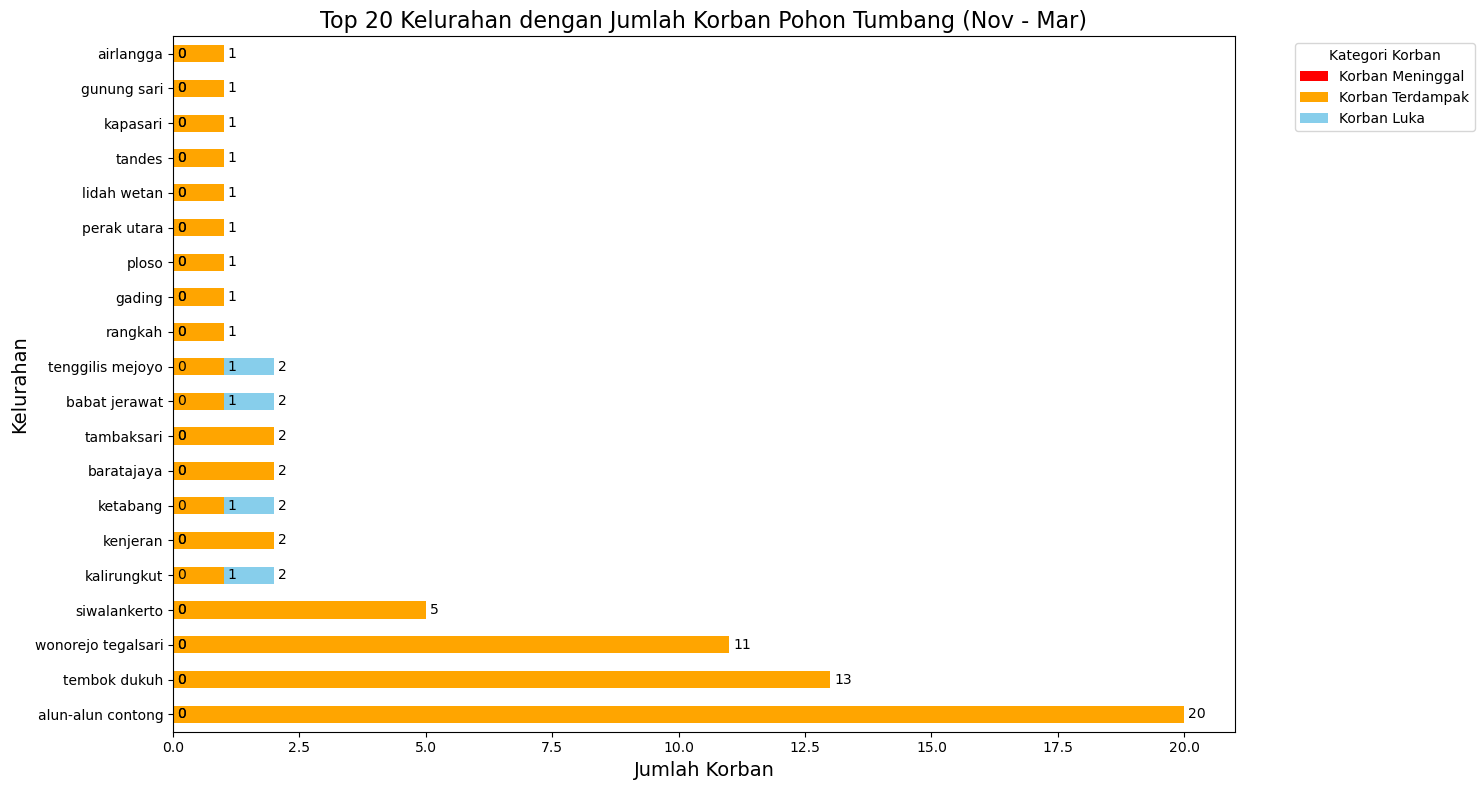

In [23]:
# Filter data untuk kejadian 'kecelakaan'
df_pt = df_filtered[df_filtered['JENIS KEJADIAN'].str.lower() == 'pohon tumbang']

# Kelompokkan data berdasarkan 'KELURAHAN' dan hitung total korban
df_grouped_pt = df_pt.groupby('KELURAHAN').agg({
    'KORBAN MENINGGAL': 'sum',
    'KORBAN TERDAMPAK': 'sum',
    'KORBAN LUKA': 'sum'
}).reset_index()

# Tambahkan kolom 'TOTAL KORBAN' untuk sort
df_grouped_pt['TOTAL KORBAN'] = (
    df_grouped_pt['KORBAN MENINGGAL'].astype(float).fillna(0) +  # Pastikan semua kolom adalah float
    df_grouped_pt['KORBAN TERDAMPAK'].astype(float).fillna(0) +
    df_grouped_pt['KORBAN LUKA'].astype(float).fillna(0)
)

# Urutkan data berdasarkan 'TOTAL KORBAN' dan ambil 20 teratas
df_top20_pt= df_grouped_pt.sort_values(by='TOTAL KORBAN', ascending=False).head(20)

# Plot bar chart horizontal untuk 20 kelurahan teratas
ax = df_top20_pt.set_index('KELURAHAN').drop(columns='TOTAL KORBAN').plot(
    kind='barh',
    figsize=(15, 8),
    stacked=True,
    color=['red', 'orange', 'skyblue']  # Mengubah warna sesuai permintaan
)

# Tambahkan label angka di atas setiap bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10, color='black', padding=3)

# Tambahkan judul dan label
plt.title('Top 20 Kelurahan dengan Jumlah Korban Pohon Tumbang (Nov - Mar)', fontsize=16)
plt.xlabel('Jumlah Korban', fontsize=14)
plt.ylabel('Kelurahan', fontsize=14)
plt.legend(title='Kategori Korban', labels=['Korban Meninggal', 'Korban Terdampak', 'Korban Luka'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Sesuaikan layout agar rapi
plt.tight_layout()

# Tampilkan plot
plt.show()

## 5. Statistika Deskriptif Jenis Kejadian RUMAH ROBOH

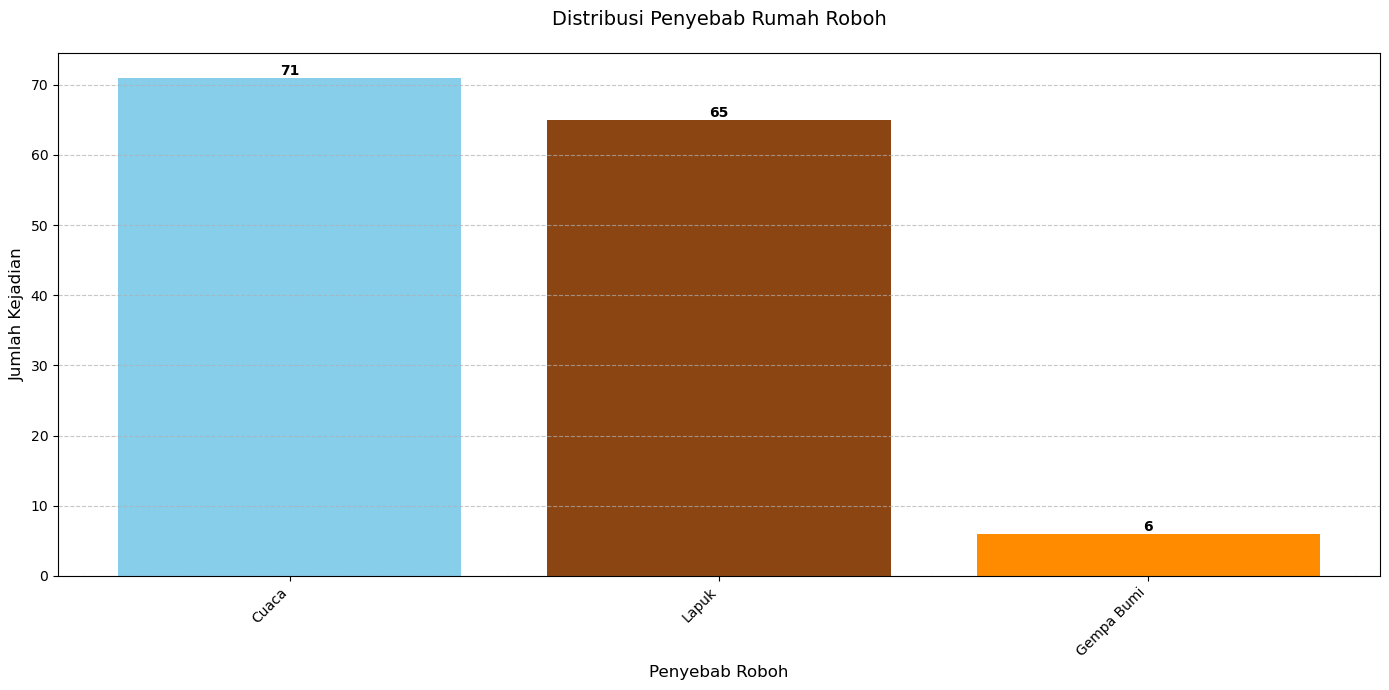


Analisis Penyebab Rumah Roboh:
Total kejadian Rumah Roboh: 142

Distribusi penyebab roboh:
Cuaca: 71 kejadian (50.0%)
Lapuk: 65 kejadian (45.8%)
Gempa Bumi: 6 kejadian (4.2%)

Penyebab roboh terbanyak: Cuaca (71 kejadian)


In [24]:
# Filter data untuk kejadian Rumah Roboh
df_roboh = df_filtered[df_filtered['JENIS KEJADIAN'] == 'Rumah Roboh'].copy()

# Hapus data kosong dan strip whitespace
df_roboh['PENYEBAB ROBOH'] = df_roboh['PENYEBAB ROBOH'].str.strip()

# Hitung frekuensi dari setiap penyebab roboh
cause_counts = df_roboh['PENYEBAB ROBOH'].value_counts()

# Tentukan warna berdasarkan kategori penyebab
color_map = {
    'Cuaca': 'skyblue',
    'Lapuk': 'saddlebrown',
    'Gempa Bumi': 'darkorange',
    'Angin Kencang': 'deepskyblue',
    'Tanah Longsor': 'forestgreen',
    'Struktur Lemah': 'gray',
    'Lainnya': 'lightgray'
}

# Ambil warna untuk setiap kategori, default ke 'lightgray' jika tidak ada di color_map
colors = [color_map.get(cause, 'lightgray') for cause in cause_counts.index]

# Buat figure dan bar chart dengan warna berbeda
plt.figure(figsize=(14, 7))
bars = plt.bar(cause_counts.index, cause_counts.values, color=colors)

# Tambahkan label nilai di atas setiap bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', 
             ha='center', va='bottom', fontsize=10, weight='bold')

# Tambahkan judul dan label sumbu
plt.title('Distribusi Penyebab Rumah Roboh', fontsize=14, pad=20)
plt.xlabel('Penyebab Roboh', fontsize=12)
plt.ylabel('Jumlah Kejadian', fontsize=12)

# Atur rotasi label x agar mudah dibaca
plt.xticks(rotation=45, ha='right')

# Tambahkan grid untuk sumbu y
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan grafik
plt.tight_layout()
plt.show()

# Analisis dan cetak hasil
print("\nAnalisis Penyebab Rumah Roboh:")
print(f"Total kejadian Rumah Roboh: {len(df_roboh)}")
print("\nDistribusi penyebab roboh:")
for cause, count in cause_counts.items():
    percentage = (count / len(df_roboh)) * 100
    print(f"{cause}: {count} kejadian ({percentage:.1f}%)")

# Penyebab roboh terbanyak
most_common_cause = cause_counts.index[0]
most_common_count = cause_counts.values[0]
print(f"\nPenyebab roboh terbanyak: {most_common_cause} ({most_common_count} kejadian)")

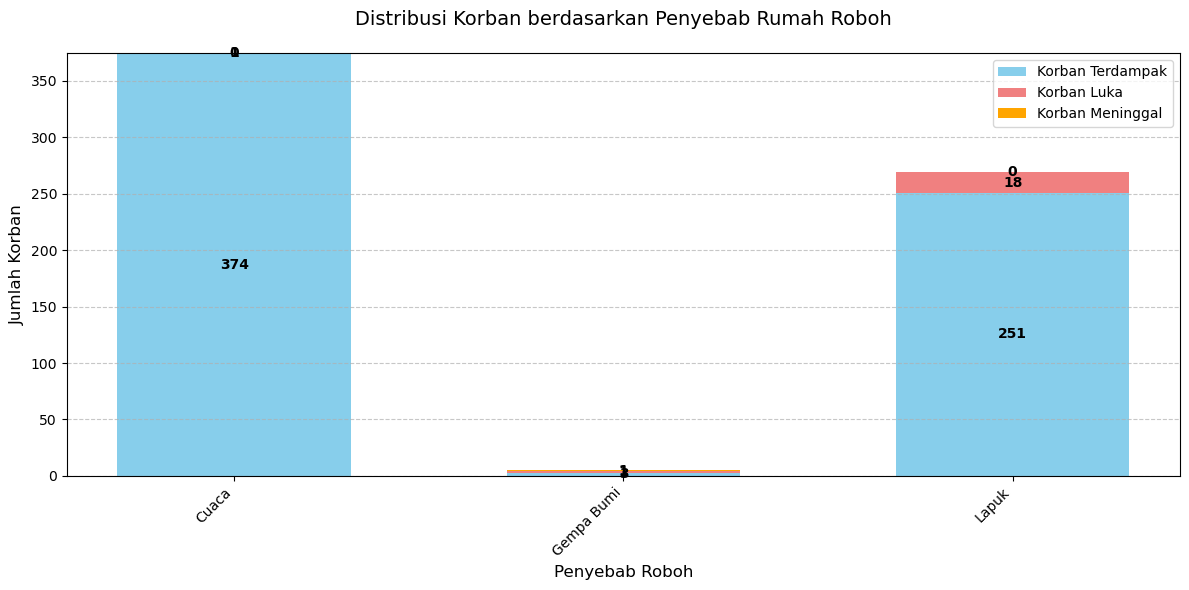


Analisis Korban berdasarkan Penyebab Rumah Roboh:
Total kejadian Rumah Roboh: 142

Distribusi korban berdasarkan penyebab roboh:
                KORBAN_TERDAMPAK  KORBAN_LUKA KORBAN_MENINGGAL
PENYEBAB ROBOH                                                
Cuaca                      374.0          1.0                0
Gempa Bumi                   3.0          1.0                1
Lapuk                      251.0         18.0                0


In [25]:
# Filter data untuk kejadian Rumah Roboh
df_roboh = df_filtered[df_filtered['JENIS KEJADIAN'] == 'Rumah Roboh'].copy()

# Hapus data kosong dan strip whitespace
df_roboh['PENYEBAB ROBOH'] = df_roboh['PENYEBAB ROBOH'].str.strip()

# Menghitung total korban berdasarkan penyebab
grouped_data = df_roboh.groupby('PENYEBAB ROBOH').agg(
    KORBAN_TERDAMPAK=('KORBAN TERDAMPAK', 'sum'),
    KORBAN_LUKA=('KORBAN LUKA', 'sum'),
    KORBAN_MENINGGAL=('KORBAN MENINGGAL', 'sum')
).reset_index()

# Set penyebab roboh sebagai index
grouped_data.set_index('PENYEBAB ROBOH', inplace=True)

# Buat grafik stacked bar
plt.figure(figsize=(12, 6))
bar_width = 0.6
bars1 = plt.bar(grouped_data.index, grouped_data['KORBAN_TERDAMPAK'], bar_width, label='Korban Terdampak', color='skyblue')
bars2 = plt.bar(grouped_data.index, grouped_data['KORBAN_LUKA'], bar_width, 
                 bottom=grouped_data['KORBAN_TERDAMPAK'], label='Korban Luka', color='lightcoral')
bars3 = plt.bar(grouped_data.index, grouped_data['KORBAN_MENINGGAL'], bar_width, 
                 bottom=grouped_data['KORBAN_TERDAMPAK'] + grouped_data['KORBAN_LUKA'], 
                 label='Korban Meninggal', color='orange')

# Tambahkan label nilai di atas setiap bar
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, 
                 f'{int(height)}', ha='center', va='center', fontsize=10, weight='bold', color='black')

# Tambahkan label untuk setiap grup bar
add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

# Tambahkan judul dan label sumbu
plt.title('Distribusi Korban berdasarkan Penyebab Rumah Roboh', fontsize=14, pad=20)
plt.xlabel('Penyebab Roboh', fontsize=12)
plt.ylabel('Jumlah Korban', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Tambahkan legenda
plt.legend()

# Tampilkan grid untuk sumbu y
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan grafik
plt.tight_layout()
plt.show()

# Analisis dan cetak hasil
print("\nAnalisis Korban berdasarkan Penyebab Rumah Roboh:")
print(f"Total kejadian Rumah Roboh: {len(df_roboh)}")
print("\nDistribusi korban berdasarkan penyebab roboh:")
print(grouped_data[['KORBAN_TERDAMPAK', 'KORBAN_LUKA', 'KORBAN_MENINGGAL']])

# PERSIAPAN DATA

In [26]:
# Grouping data per kelurahan dan jenis kejadian untuk menghitung frekuensi
df_grouped = df_filtered.groupby(['KELURAHAN', 'JENIS KEJADIAN']).size().reset_index(name='FREKUENSI')

# Pivot data agar siap untuk clustering (kelurahan sebagai row, jenis kejadian sebagai column)
df_pivot = df_grouped.pivot_table(values='FREKUENSI', index='KELURAHAN', columns='JENIS KEJADIAN', fill_value=0)

# Tampilkan data hasil pivot
df_pivot

JENIS KEJADIAN,Darurat Medis,Genangan,Kebakaran,Kecelakaan,Pohon Tumbang,Rumah Roboh
KELURAHAN,,,,,,
airlangga,51.0,2.0,3.0,52.0,4.0,0.0
alun-alun contong,20.0,0.0,2.0,37.0,5.0,3.0
ampel,14.0,0.0,1.0,1.0,0.0,0.0
asem rowo,34.0,0.0,7.0,56.0,2.0,1.0
babat jerawat,30.0,2.0,4.0,12.0,2.0,1.0
...,...,...,...,...,...,...
wiyung,18.0,2.0,1.0,11.0,1.0,1.0
wonokromo,30.0,0.0,2.0,67.0,1.0,0.0
wonokusumo,33.0,1.0,4.0,2.0,0.0,1.0


In [27]:
# 2. Menambahkan fitur KORBAN TERDAMPAK, KORBAN LUKA, KORBAN MENINGGAL ke df_pivot
df_victims = df_filtered.groupby('KELURAHAN').agg({
    'KORBAN TERDAMPAK': 'sum',
    'KORBAN LUKA': 'sum',
    'KORBAN MENINGGAL': 'sum'
}).reset_index()

df_victims

,KELURAHAN,KORBAN TERDAMPAK,KORBAN LUKA,KORBAN MENINGGAL
0,airlangga,153.0,126.0,14
1,alun-alun contong,111.0,76.0,3
2,ampel,17.0,14.0,1
3,asem rowo,135.0,101.0,12
4,babat jerawat,55.0,48.0,2
...,...,...,...,...
148,wiyung,39.0,24.0,4
149,wonokromo,154.0,136.0,7
150,wonokusumo,41.0,34.0,4
151,wonorejo rungkut,34.0,28.0,4


In [28]:
# Menggabungkan data pivot dengan data korban
df_combined = df_pivot.merge(df_victims, on='KELURAHAN')
df_combined.tail()

,KELURAHAN,Darurat Medis,Genangan,Kebakaran,Kecelakaan,Pohon Tumbang,Rumah Roboh,KORBAN TERDAMPAK,KORBAN LUKA,KORBAN MENINGGAL
148,wiyung,18.0,2.0,1.0,11.0,1.0,1.0,39.0,24.0,4
149,wonokromo,30.0,0.0,2.0,67.0,1.0,0.0,154.0,136.0,7
150,wonokusumo,33.0,1.0,4.0,2.0,0.0,1.0,41.0,34.0,4
151,wonorejo rungkut,24.0,0.0,4.0,5.0,1.0,0.0,34.0,28.0,4
152,wonorejo tegalsari,27.0,0.0,4.0,14.0,1.0,0.0,72.0,44.0,2


In [29]:
# Simpan df_bulanan ke dalam file Excel
output_file = 'data untuk clustering.xlsx'  # Nama file output
df_combined.to_excel(output_file, sheet_name='Data Clustering')

print(f"Data berhasil disimpan dalam file: {output_file}")

Data berhasil disimpan dalam file: data untuk clustering.xlsx


# Deteksi Outlier

In [30]:
# Memilih semua kolom kecuali 'KELURAHAN'
numeric_columns = df_combined.select_dtypes(include=[np.number]).columns

# Fungsi untuk mendeteksi outlier menggunakan IQR
def detect_outliers(df, columns):
    outlier_indices = []
    
    for column in columns:
        # Menghitung Q1, Q3, dan IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Menghitung batas outlier
        outlier_low = Q1 - 1.5 * IQR
        outlier_high = Q3 + 1.5 * IQR
        
        # Mencari outlier
        outliers = df[(df[column] < outlier_low) | (df[column] > outlier_high)]
        
        print(f"\nOutlier di kolom {column}:")
        print(f"Batas bawah: {outlier_low:.2f}")
        print(f"Batas atas: {outlier_high:.2f}")
        print(f"Jumlah outlier: {len(outliers)}")
        if len(outliers) > 0:
            print("Nilai outlier:")
            print(outliers[['KELURAHAN', column]])
            
        # Menyimpan index outlier
        outlier_indices.extend(outliers.index)
    
    return list(set(outlier_indices))

# Menjalankan deteksi outlier
outlier_indices = detect_outliers(df_combined, numeric_columns)

print(f"\nTotal baris data yang memiliki outlier: {len(set(outlier_indices))}")


Outlier di kolom Darurat Medis:
Batas bawah: -24.00
Batas atas: 80.00
Jumlah outlier: 4
Nilai outlier:
      KELURAHAN  Darurat Medis
27       gading          175.0
106       ploso           88.0
110  putat jaya           84.0
127   simomulyo          106.0

Outlier di kolom Genangan:
Batas bawah: -1.50
Batas atas: 2.50
Jumlah outlier: 20
Nilai outlier:
            KELURAHAN  Genangan
13             benowo       4.0
20       dukuh kupang       7.0
22        dukuh pakis       3.0
44        kalirungkut       3.0
46          kandangan       8.0
48           kapasari       3.0
61        kendangsari       4.0
67          ketintang       3.0
73        lakarsantri       3.0
74        lidah kulon       5.0
76             lontar       4.0
78      manukan kulon       7.0
90        ngagel rejo       6.0
96              pakal       6.0
101   penjaringansari       3.0
104       perak utara       9.0
105           petemon       5.0
106             ploso       3.0
109        putat gede       3.0
145

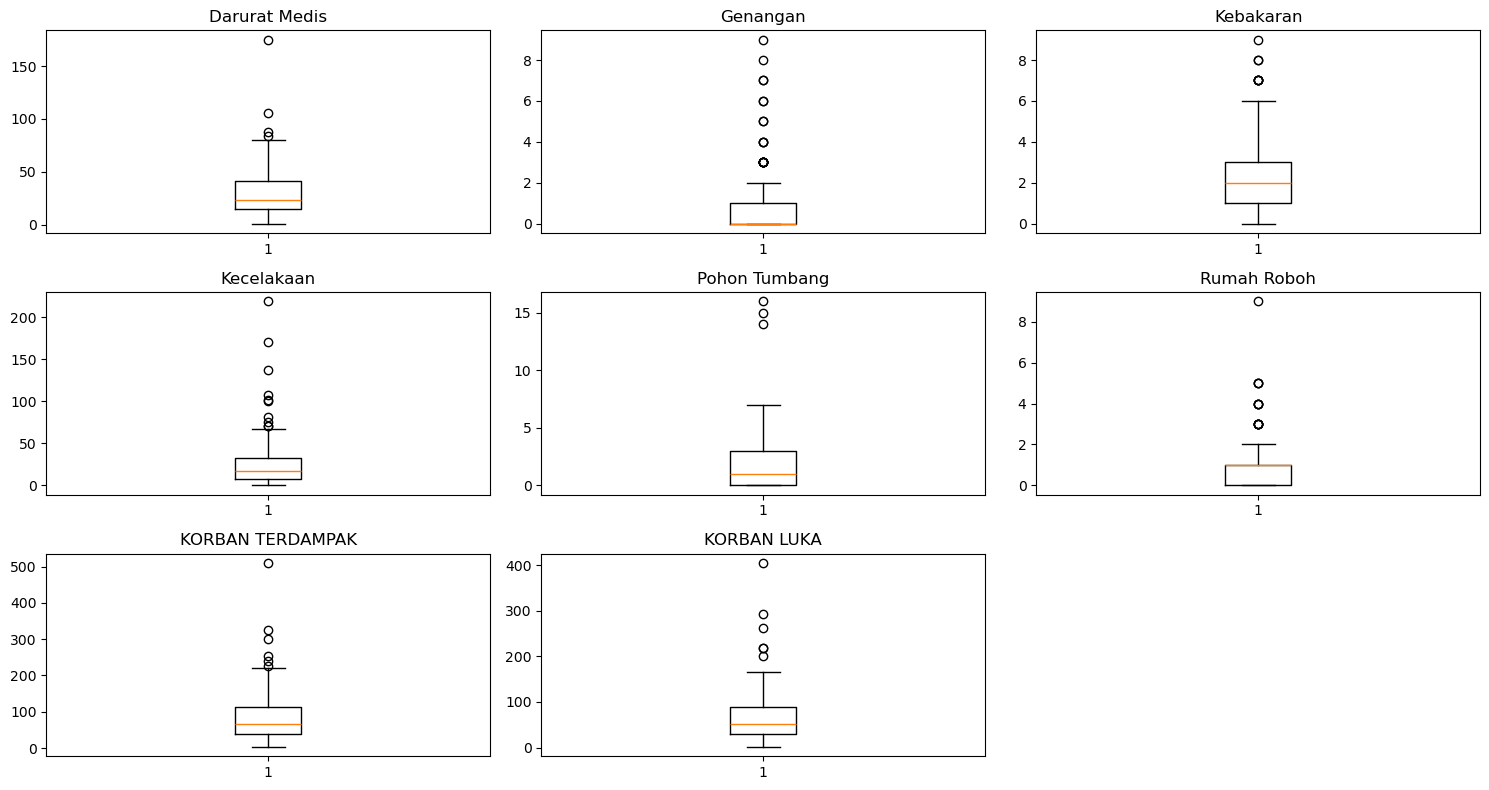

In [31]:
# Ambil semua kolom numerik kecuali 'KELURAHAN'
numeric_columns = df_combined.select_dtypes(include=['float64', 'int64']).columns

# Buat boxplot untuk setiap kolom numerik
plt.figure(figsize=(15, 8))

for i, column in enumerate(numeric_columns):
    plt.subplot(3, (len(numeric_columns) + 2) // 3, i + 1)  # Mengatur layout subplot
    plt.boxplot(df_combined[column])
    plt.title(column)

plt.tight_layout()
plt.show()

- **Darurat Medis:**
    - Mayoritas nilai berada di bawah 50 kejadian.
    - Ada beberapa outlier di atas 100 kejadian, menunjukkan bahwa beberapa kasus darurat medis sangat tinggi dibandingkan rata-rata.

- **Genangan:**
    - Kebanyakan nilai mendekati 0 kejadian.
    - Outlier muncul hingga 8 kejadian, mengindikasikan beberapa waktu terdapat lebih banyak genangan dari biasanya.

- **Kebakaran:**
    - Distribusi relatif kecil (sekitar 2–3 kejadian dalam banyak kasus).
    - Ada beberapa outlier di sekitar 5 hingga 8 kejadian.

- **Kecelakaan:**
    - Terdapat kejadian dengan variasi yang lebih tinggi dibandingkan kategori lain.
    - Outlier signifikan muncul hingga lebih dari 200 kejadian, menunjukkan adanya periode dengan lonjakan kecelakaan.

- **Pohon Tumbang:**
    - Mayoritas nilai mendekati 0 kejadian, namun beberapa kejadian outlier mencapai 15 kejadian.

- **Rumah Roboh:**
    - Sebagian besar kejadian di sekitar 0–2, tetapi ada outlier hingga 8 kejadian.

- **KORBAN TERDAMPAK:**
    - Sebagian besar data berkisar di sekitar 100–150 korban, namun terdapat outlier di sekitar 300 dan 500 korban.

- **KORBAN LUKA:**
    - Distribusi mirip dengan korban terdampak, dengan outlier signifikan hingga 400 korban luka.

- **Kesimpulan:**
    - Darurat Medis dan Kecelakaan memiliki beberapa nilai ekstrem yang signifikan. Ini bisa menunjukkan insiden dengan jumlah kejadian yang tinggi pada waktu tertentu.
    - Kategori Genangan, Pohon Tumbang, dan Rumah Roboh memiliki beberapa outlier meskipun mayoritas kejadian rendah. Outlier ini mungkin terjadi saat cuaca ekstrem atau kondisi lingkungan tertentu.
    - Korban Terdampak dan Korban Luka juga menunjukkan adanya periode dengan lonjakan korban yang signifikan, yang bisa jadi perlu ditindaklanjuti lebih lanjut (misalnya, untuk kesiapsiagaan lebih baik atau identifikasi pola kejadian).

# Memilih fitur untuk clustering

In [32]:
# Mengambil semua kolom kecuali 'KELURAHAN'
features = df_combined.drop(columns=['KELURAHAN'])
features.head()

,Darurat Medis,Genangan,Kebakaran,Kecelakaan,Pohon Tumbang,Rumah Roboh,KORBAN TERDAMPAK,KORBAN LUKA,KORBAN MENINGGAL
0,51.0,2.0,3.0,52.0,4.0,0.0,153.0,126.0,14
1,20.0,0.0,2.0,37.0,5.0,3.0,111.0,76.0,3
2,14.0,0.0,1.0,1.0,0.0,0.0,17.0,14.0,1
3,34.0,0.0,7.0,56.0,2.0,1.0,135.0,101.0,12
4,30.0,2.0,4.0,12.0,2.0,1.0,55.0,48.0,2


# Standarisasi Data

In [33]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

norm_all = pd.DataFrame(scaled_data, columns = features.columns)
norm_all

,Darurat Medis,Genangan,Kebakaran,Kecelakaan,Pohon Tumbang,Rumah Roboh,KORBAN TERDAMPAK,KORBAN LUKA,KORBAN MENINGGAL
0,0.941368,0.591029,0.269444,0.821330,0.780174,-0.700980,1.007598,1.015553,2.728202
1,-0.399043,-0.591029,-0.245868,0.335392,1.180733,1.564865,0.391886,0.151661,-0.338975
2,-0.658477,-0.591029,-0.761180,-0.830858,-0.822063,-0.700980,-0.986136,-0.919565,-0.896644
3,0.206304,-0.591029,2.330693,0.950913,-0.020944,0.054301,0.743722,0.583607,2.170533
4,0.033348,0.591029,0.784756,-0.474504,-0.020944,0.054301,-0.429063,-0.332118,-0.617809
...,...,...,...,...,...,...,...,...,...
148,-0.485521,0.591029,-0.761180,-0.506900,-0.421504,0.054301,-0.663620,-0.746786,-0.060141
149,0.033348,-0.591029,-0.245868,1.307268,-0.421504,-0.700980,1.022258,1.188331,0.776362
150,0.163065,0.000000,0.784756,-0.798462,-0.822063,0.054301,-0.634300,-0.574008,-0.060141
151,-0.226087,-0.591029,0.784756,-0.701275,-0.421504,-0.700980,-0.736919,-0.677675,-0.060141


In [34]:
# Mengonversi DataFrame menjadi array NumPy
norm_all_array = norm_all.to_numpy() 

# Penentuan Jumlah Cluster Optimal


Evaluating silhouette scores for linkage method: ward
For n_clusters = 2, the average silhouette score is : 0.32
For n_clusters = 3, the average silhouette score is : 0.31
For n_clusters = 4, the average silhouette score is : 0.32
For n_clusters = 5, the average silhouette score is : 0.31
For n_clusters = 6, the average silhouette score is : 0.17
For n_clusters = 7, the average silhouette score is : 0.18
For n_clusters = 8, the average silhouette score is : 0.19
For n_clusters = 9, the average silhouette score is : 0.19
For n_clusters = 10, the average silhouette score is : 0.19

Evaluating silhouette scores for linkage method: single
For n_clusters = 2, the average silhouette score is : 0.66
For n_clusters = 3, the average silhouette score is : 0.61
For n_clusters = 4, the average silhouette score is : 0.52
For n_clusters = 5, the average silhouette score is : 0.52
For n_clusters = 6, the average silhouette score is : 0.50
For n_clusters = 7, the average silhouette score is : 0.47
Fo

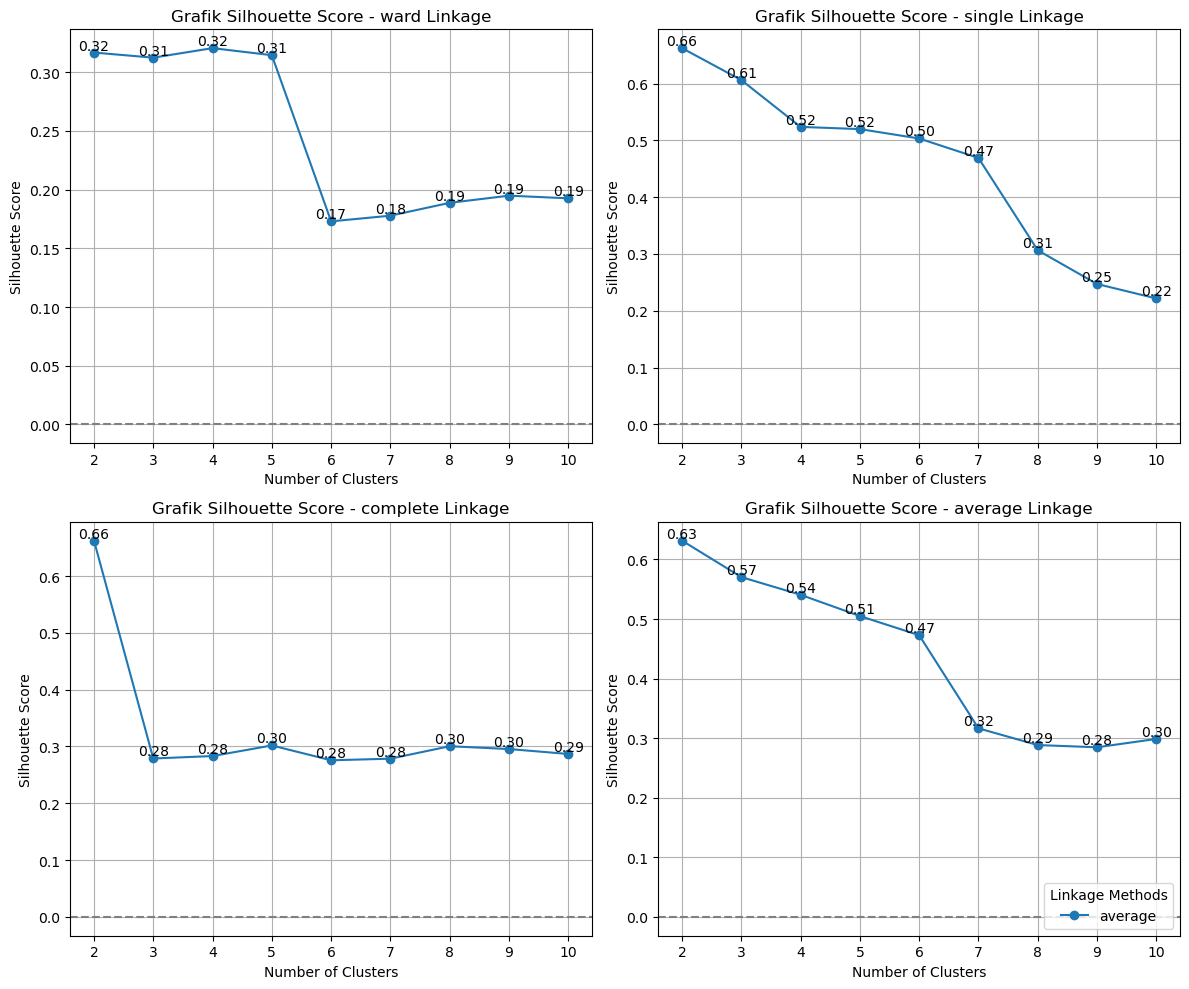

In [35]:
# Daftar untuk menyimpan hasil
linkage_methods = ['ward', 'single', 'complete', 'average']
silhouette_scores = {method: [] for method in linkage_methods}  # Menggunakan dictionary untuk menyimpan scores

# Loop untuk mengevaluasi Silhouette Score untuk setiap metode linkage
for method in linkage_methods:
    print(f'\nEvaluating silhouette scores for linkage method: {method}')
    for n_clusters in range(2, 11):  # Coba jumlah cluster dari 2 hingga 10
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
        cluster_labels = model.fit_predict(norm_all)

        # Hitung Silhouette Score
        silhouette_avg = silhouette_score(norm_all, cluster_labels)
        silhouette_scores[method].append(silhouette_avg)  # Simpan Silhouette Score ke dalam dictionary
        print(f'For n_clusters = {n_clusters}, the average silhouette score is : {silhouette_avg:.2f}')

# Plot Silhouette Score untuk setiap metode di subplot terpisah
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Rata-rata semua axes menjadi array 1D untuk kemudahan iterasi

for i, method in enumerate(linkage_methods):
    axes[i].plot(range(2, 11), silhouette_scores[method], marker='o', label=method)
    
    # Menambahkan keterangan pada grafik
    axes[i].set_title(f'Grafik Silhouette Score - {method} Linkage')
    axes[i].set_xlabel('Number of Clusters')
    axes[i].set_ylabel('Silhouette Score')
    axes[i].set_xticks(range(2, 11))  # Menampilkan angka di sumbu X sesuai dengan jumlah cluster
    axes[i].grid()
    axes[i].axhline(y=0, color='grey', linestyle='--')  # Garis horizontal di y=0

    # Menambahkan keterangan nomor di grafik untuk setiap metode
    for j, score in enumerate(silhouette_scores[method]):
        axes[i].text(j + 2, score, f'{score:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.legend(title='Linkage Methods', loc='lower right')
plt.show()

- **Ward Linkage:**
    - Tren skor meningkat dari cluster 2 hingga 4, dengan nilai tertinggi di cluster 4 (0.34)
    - Setelah cluster 5, nilai menurun drastis dan stabil di sekitar 0.17-0.18
    - Rekomendasi: 4 cluster (skor 0.34) karena memberikan nilai Silhouette tertinggi dan setelahnya terjadi penurunan signifikan

- **Single Linkage:**
    - Nilai tertinggi pada cluster 3 (0.60)
    - Terjadi penurunan gradual setelah cluster 3
    - Rekomendasi: 3 cluster (skor 0.60) karena memberikan nilai Silhouette tertinggi dan menunjukkan konsistensi sebelum mulai menurun

- **Complete Linkage:**
    - Nilai tertinggi pada cluster 2 (0.64)
    - Terjadi penurunan konsisten setelah cluster 2
    - Rekomendasi: 2 cluster (skor 0.64) karena memberikan nilai Silhouette tertinggi dan menunjukkan tren penurunan setelahnya

- **Average Linkage:**
    - Nilai tertinggi pada cluster 2 (0.62)
    - Terjadi penurunan bertahap setelah cluster 2
    - Rekomendasi: 2 cluster (skor 0.62) karena memberikan nilai Silhouette tertinggi dan menunjukkan penurunan konsisten setelahnya

- **Kesimpulan:**
    1. Ward Linkage: 4 cluster
    2. Single Linkage: 3 cluster
    3. Complete Linkage: 2 cluster
    4. Average Linkage: 2 cluster

# Pemodelan Hierarchihal Aglomerative CLustering

## - Ward Linkage for 4 cluster

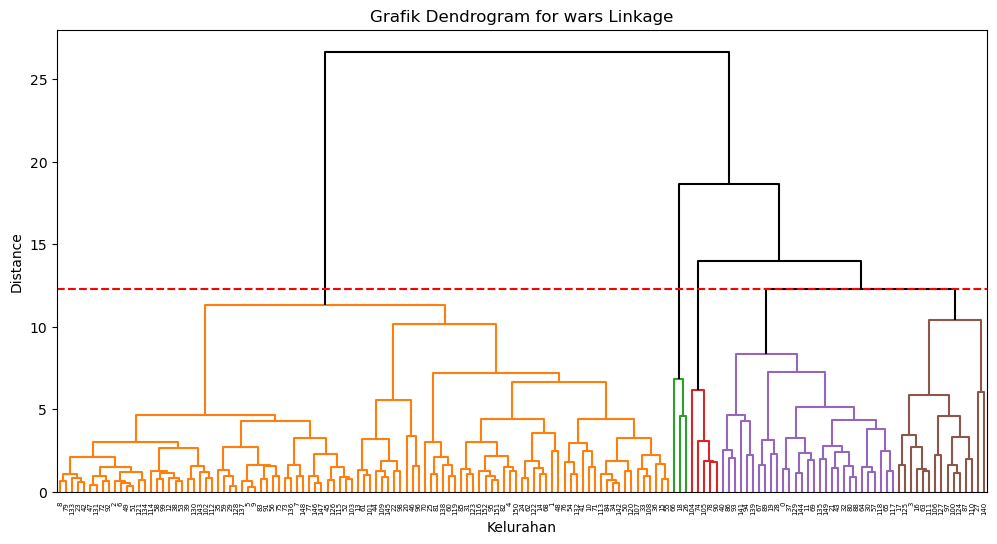

In [36]:
# Membuat linkage matrix
Z_ward = linkage(norm_all, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(
    Z_ward,
    color_threshold=Z_ward[-4, 2],  # Threshold to get 3 clusters
    above_threshold_color='k',  # Color above threshold
)
plt.axhline(y=Z_ward[-4, 2], color='r', linestyle='--')
plt.title(f'Grafik Dendrogram for wars Linkage')
plt.xlabel('Kelurahan')
plt.ylabel('Distance')
plt.show()

# Menggunakan AgglomerativeClustering untuk mendapatkan label cluster
model = AgglomerativeClustering(n_clusters=4, linkage='ward')
cluster_labels = model.fit_predict(norm_all)

In [37]:
if isinstance(norm_all, pd.DataFrame):
    df_ward = norm_all.copy()
    df_ward['Cluster'] = cluster_labels
else:
    # If norm_all is a NumPy array
    df_ward = pd.DataFrame(norm_all)
    df_ward['Cluster'] = cluster_labels

df_ward

,Darurat Medis,Genangan,Kebakaran,Kecelakaan,Pohon Tumbang,Rumah Roboh,KORBAN TERDAMPAK,KORBAN LUKA,KORBAN MENINGGAL,Cluster
0,0.941368,0.591029,0.269444,0.821330,0.780174,-0.700980,1.007598,1.015553,2.728202,0
1,-0.399043,-0.591029,-0.245868,0.335392,1.180733,1.564865,0.391886,0.151661,-0.338975,1
2,-0.658477,-0.591029,-0.761180,-0.830858,-0.822063,-0.700980,-0.986136,-0.919565,-0.896644,1
3,0.206304,-0.591029,2.330693,0.950913,-0.020944,0.054301,0.743722,0.583607,2.170533,0
4,0.033348,0.591029,0.784756,-0.474504,-0.020944,0.054301,-0.429063,-0.332118,-0.617809,1
...,...,...,...,...,...,...,...,...,...,...
148,-0.485521,0.591029,-0.761180,-0.506900,-0.421504,0.054301,-0.663620,-0.746786,-0.060141,1
149,0.033348,-0.591029,-0.245868,1.307268,-0.421504,-0.700980,1.022258,1.188331,0.776362,0
150,0.163065,0.000000,0.784756,-0.798462,-0.822063,0.054301,-0.634300,-0.574008,-0.060141,1
151,-0.226087,-0.591029,0.784756,-0.701275,-0.421504,-0.700980,-0.736919,-0.677675,-0.060141,1


In [38]:
count_ward = df_ward['Cluster'].value_counts().sort_index()
count_ward

Cluster
0     44
1    101
2      3
3      5
Name: count, dtype: int64

## - Single Linkage for 3 cluster

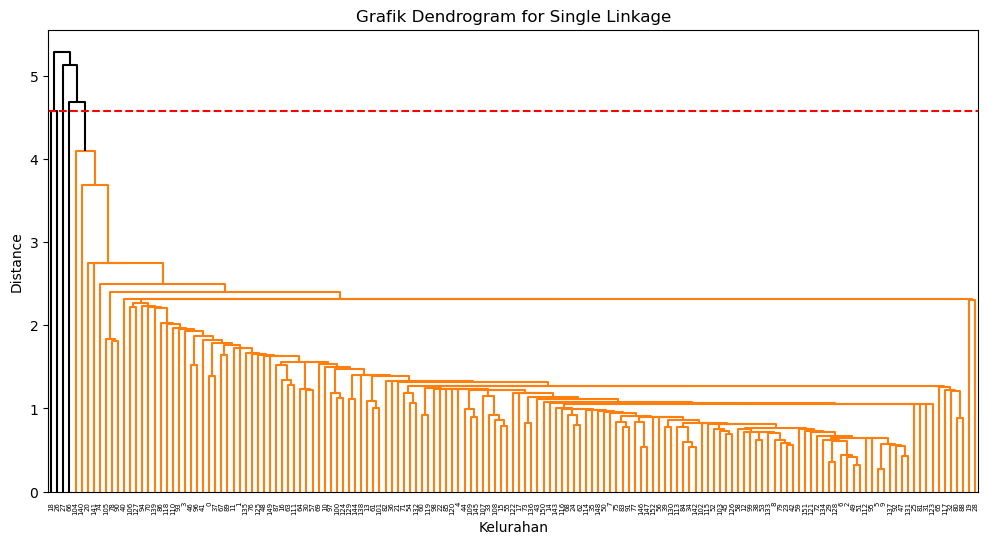

In [39]:
Z_single = linkage(norm_all, method='single')

plt.figure(figsize=(12, 6))
dendrogram(
    Z_single,
    color_threshold=Z_single[-4, 2],  # Threshold to get 3 clusters
    above_threshold_color='k',  # Color above threshold
)
plt.axhline(y=Z_single[-4, 2], color='r', linestyle='--')
plt.title(f'Grafik Dendrogram for Single Linkage')
plt.xlabel('Kelurahan')
plt.ylabel('Distance')
plt.show()

# Sisanya sama seperti kode sebelumnya
model_single = AgglomerativeClustering(n_clusters=3, linkage='single')
cluster_labels_single = model_single.fit_predict(norm_all)

In [40]:
if isinstance(norm_all, pd.DataFrame):
    df_single = norm_all.copy()
    df_single['Cluster'] = cluster_labels_single
else:
    # If norm_all is a NumPy array
    df_single = pd.DataFrame(norm_all)
    df_single['Cluster'] = cluster_labels_single

df_single

,Darurat Medis,Genangan,Kebakaran,Kecelakaan,Pohon Tumbang,Rumah Roboh,KORBAN TERDAMPAK,KORBAN LUKA,KORBAN MENINGGAL,Cluster
0,0.941368,0.591029,0.269444,0.821330,0.780174,-0.700980,1.007598,1.015553,2.728202,0
1,-0.399043,-0.591029,-0.245868,0.335392,1.180733,1.564865,0.391886,0.151661,-0.338975,0
2,-0.658477,-0.591029,-0.761180,-0.830858,-0.822063,-0.700980,-0.986136,-0.919565,-0.896644,0
3,0.206304,-0.591029,2.330693,0.950913,-0.020944,0.054301,0.743722,0.583607,2.170533,0
4,0.033348,0.591029,0.784756,-0.474504,-0.020944,0.054301,-0.429063,-0.332118,-0.617809,0
...,...,...,...,...,...,...,...,...,...,...
148,-0.485521,0.591029,-0.761180,-0.506900,-0.421504,0.054301,-0.663620,-0.746786,-0.060141,0
149,0.033348,-0.591029,-0.245868,1.307268,-0.421504,-0.700980,1.022258,1.188331,0.776362,0
150,0.163065,0.000000,0.784756,-0.798462,-0.822063,0.054301,-0.634300,-0.574008,-0.060141,0
151,-0.226087,-0.591029,0.784756,-0.701275,-0.421504,-0.700980,-0.736919,-0.677675,-0.060141,0


In [41]:
count_single = df_single['Cluster'].value_counts().sort_index()
count_single

Cluster
0    150
1      2
2      1
Name: count, dtype: int64

## - Complete Linkage for 4 cluster

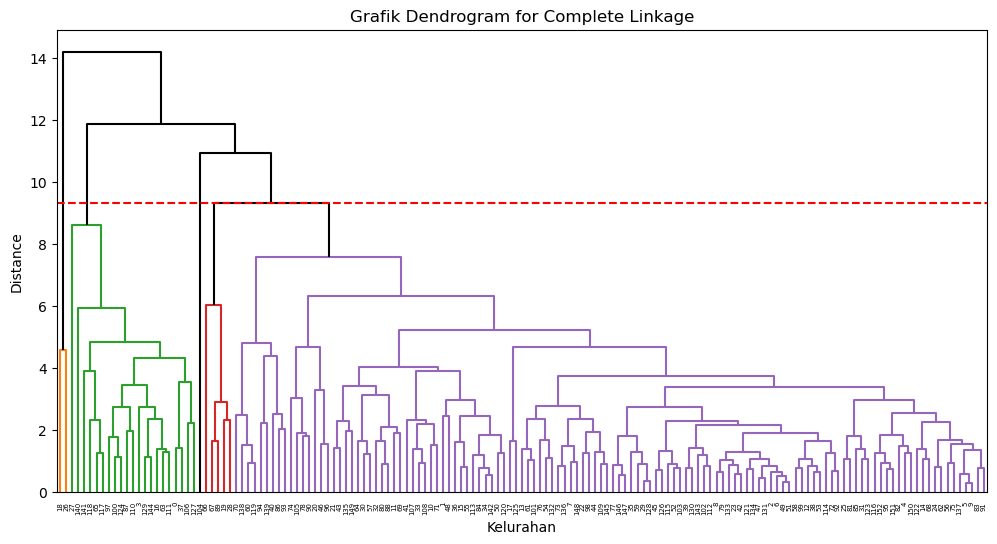

In [42]:
Z_complete = linkage(norm_all, method='complete')

plt.figure(figsize=(12, 6))
dendrogram(
    Z_complete,
    color_threshold=Z_complete[-4, 2],  # Threshold to get 3 clusters
    above_threshold_color='k',  # Color above threshold
)
plt.axhline(y=Z_complete[-4, 2], color='r', linestyle='--')
plt.title(f'Grafik Dendrogram for Complete Linkage')
plt.xlabel('Kelurahan')
plt.ylabel('Distance')
plt.show()

# Menggunakan AgglomerativeClustering untuk mendapatkan label cluster
model_complete = AgglomerativeClustering(n_clusters=4, linkage='complete')
cluster_labels_complete = model_complete.fit_predict(norm_all)

In [43]:
if isinstance(norm_all, pd.DataFrame):
    df_cmpt = norm_all.copy()
    df_cmpt['Cluster'] = cluster_labels_complete
else:
    # If norm_all is a NumPy array
    df_cmpt = pd.DataFrame(norm_all)
    df_cmpt['Cluster'] = cluster_labels_complete

df_cmpt

,Darurat Medis,Genangan,Kebakaran,Kecelakaan,Pohon Tumbang,Rumah Roboh,KORBAN TERDAMPAK,KORBAN LUKA,KORBAN MENINGGAL,Cluster
0,0.941368,0.591029,0.269444,0.821330,0.780174,-0.700980,1.007598,1.015553,2.728202,2
1,-0.399043,-0.591029,-0.245868,0.335392,1.180733,1.564865,0.391886,0.151661,-0.338975,0
2,-0.658477,-0.591029,-0.761180,-0.830858,-0.822063,-0.700980,-0.986136,-0.919565,-0.896644,0
3,0.206304,-0.591029,2.330693,0.950913,-0.020944,0.054301,0.743722,0.583607,2.170533,2
4,0.033348,0.591029,0.784756,-0.474504,-0.020944,0.054301,-0.429063,-0.332118,-0.617809,0
...,...,...,...,...,...,...,...,...,...,...
148,-0.485521,0.591029,-0.761180,-0.506900,-0.421504,0.054301,-0.663620,-0.746786,-0.060141,0
149,0.033348,-0.591029,-0.245868,1.307268,-0.421504,-0.700980,1.022258,1.188331,0.776362,0
150,0.163065,0.000000,0.784756,-0.798462,-0.822063,0.054301,-0.634300,-0.574008,-0.060141,0
151,-0.226087,-0.591029,0.784756,-0.701275,-0.421504,-0.700980,-0.736919,-0.677675,-0.060141,0


In [44]:
count_cmpt = df_cmpt['Cluster'].value_counts().sort_index()
count_cmpt

Cluster
0    129
1      2
2     21
3      1
Name: count, dtype: int64

## - Average Linkage for 4 cluster

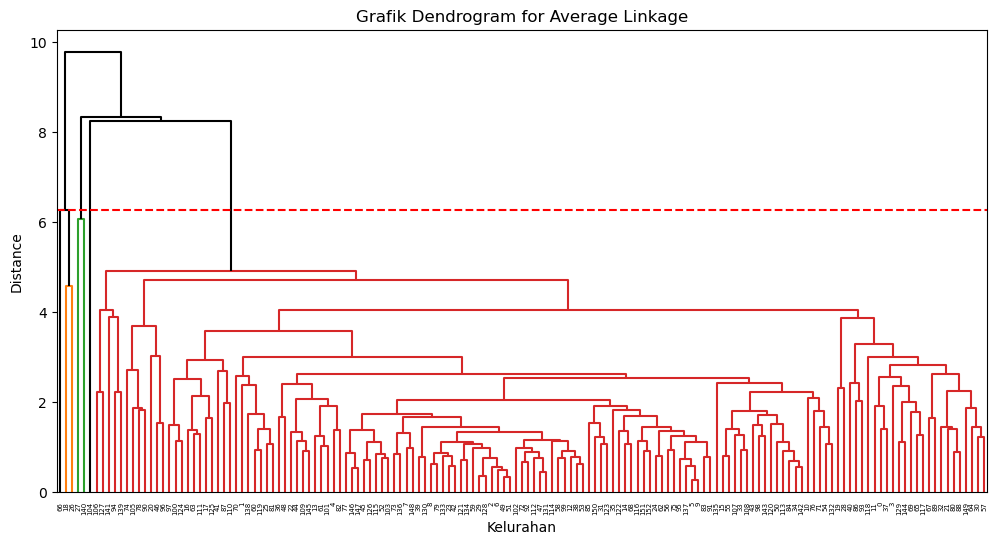

In [45]:
Z_average = linkage(norm_all, method='average')

plt.figure(figsize=(12, 6))
dendrogram(
    Z_average,
    color_threshold=Z_average[-4, 2],  # Threshold to get 3 clusters
    above_threshold_color='k',  # Color above threshold
)
plt.axhline(y=Z_average[-4, 2], color='r', linestyle='--')
plt.title(f'Grafik Dendrogram for Average Linkage')
plt.xlabel('Kelurahan')
plt.ylabel('Distance')
plt.show()

# Menggunakan AgglomerativeClustering untuk mendapatkan label cluster
model_average = AgglomerativeClustering(n_clusters=4, linkage='average')
cluster_labels_average = model_average.fit_predict(norm_all)

In [46]:
if isinstance(norm_all, pd.DataFrame):
    df_avg = norm_all.copy()
    df_avg['Cluster'] = cluster_labels_average
else:
    # If norm_all is a NumPy array
    df_avg = pd.DataFrame(norm_all)
    df_avg['Cluster'] = cluster_labels_average

df_avg

,Darurat Medis,Genangan,Kebakaran,Kecelakaan,Pohon Tumbang,Rumah Roboh,KORBAN TERDAMPAK,KORBAN LUKA,KORBAN MENINGGAL,Cluster
0,0.941368,0.591029,0.269444,0.821330,0.780174,-0.700980,1.007598,1.015553,2.728202,1
1,-0.399043,-0.591029,-0.245868,0.335392,1.180733,1.564865,0.391886,0.151661,-0.338975,1
2,-0.658477,-0.591029,-0.761180,-0.830858,-0.822063,-0.700980,-0.986136,-0.919565,-0.896644,1
3,0.206304,-0.591029,2.330693,0.950913,-0.020944,0.054301,0.743722,0.583607,2.170533,1
4,0.033348,0.591029,0.784756,-0.474504,-0.020944,0.054301,-0.429063,-0.332118,-0.617809,1
...,...,...,...,...,...,...,...,...,...,...
148,-0.485521,0.591029,-0.761180,-0.506900,-0.421504,0.054301,-0.663620,-0.746786,-0.060141,1
149,0.033348,-0.591029,-0.245868,1.307268,-0.421504,-0.700980,1.022258,1.188331,0.776362,1
150,0.163065,0.000000,0.784756,-0.798462,-0.822063,0.054301,-0.634300,-0.574008,-0.060141,1
151,-0.226087,-0.591029,0.784756,-0.701275,-0.421504,-0.700980,-0.736919,-0.677675,-0.060141,1


In [47]:
count_avg = df_avg['Cluster'].value_counts().sort_index()
count_avg

Cluster
0      3
1    147
2      2
3      1
Name: count, dtype: int64

# Chopenetic Correlation

In [48]:
# Menghitung jarak asli antar data point
original_dist = pdist(norm_all)

# Menghitung Cophenetic Correlation Coefficient untuk setiap metode
c_ward, _ = cophenet(Z_ward, original_dist)
c_single, _ = cophenet(Z_single, original_dist)
c_complete, _ = cophenet(Z_complete, original_dist)
c_average, _ = cophenet(Z_average, original_dist)

# Menampilkan hasil
print("\nCophenetic Correlation Coefficient untuk setiap metode:")
print(f"Ward Linkage (4 cluster): {c_ward:.4f}")
print(f"Single Linkage (3 cluster): {c_single:.4f}")
print(f"Complete Linkage (4 cluster): {c_complete:.4f}")
print(f"Average Linkage (4 cluster): {c_average:.4f}")

# Membuat dataframe hasil perbandingan
results = pd.DataFrame({
    'Metode': ['Ward', 'Single', 'Complete', 'Average'],
    'Jumlah Cluster': [4, 3, 4, 4],
    'Cophenetic Correlation': [c_ward, c_single, c_complete, c_average]
})

print("\nTabel Perbandingan:")
print(results)

# Mengurutkan dataframe berdasarkan Cophenetic Correlation secara descending
sorted_results = results.sort_values(by='Cophenetic Correlation', ascending=False).reset_index(drop=True)

# Menampilkan metode terbaik dan kedua terbaik
print("\nMetode terbaik ke-1:")
print(f"Metode: {sorted_results.iloc[0]['Metode']}")
print(f"Jumlah Cluster: {sorted_results.iloc[0]['Jumlah Cluster']}")
print(f"Cophenetic Correlation: {sorted_results.iloc[0]['Cophenetic Correlation']:.4f}")

print("\nMetode terbaik ke-2:")
print(f"Metode: {sorted_results.iloc[1]['Metode']}")
print(f"Jumlah Cluster: {sorted_results.iloc[1]['Jumlah Cluster']}")
print(f"Cophenetic Correlation: {sorted_results.iloc[1]['Cophenetic Correlation']:.4f}")


Cophenetic Correlation Coefficient untuk setiap metode:
Ward Linkage (4 cluster): 0.5300
Single Linkage (3 cluster): 0.9019
Complete Linkage (4 cluster): 0.6679
Average Linkage (4 cluster): 0.8916

Tabel Perbandingan:
     Metode  Jumlah Cluster  Cophenetic Correlation
0      Ward               4                0.529951
1    Single               3                0.901901
2  Complete               4                0.667904
3   Average               4                0.891616

Metode terbaik ke-1:
Metode: Single
Jumlah Cluster: 3
Cophenetic Correlation: 0.9019

Metode terbaik ke-2:
Metode: Average
Jumlah Cluster: 4
Cophenetic Correlation: 0.8916


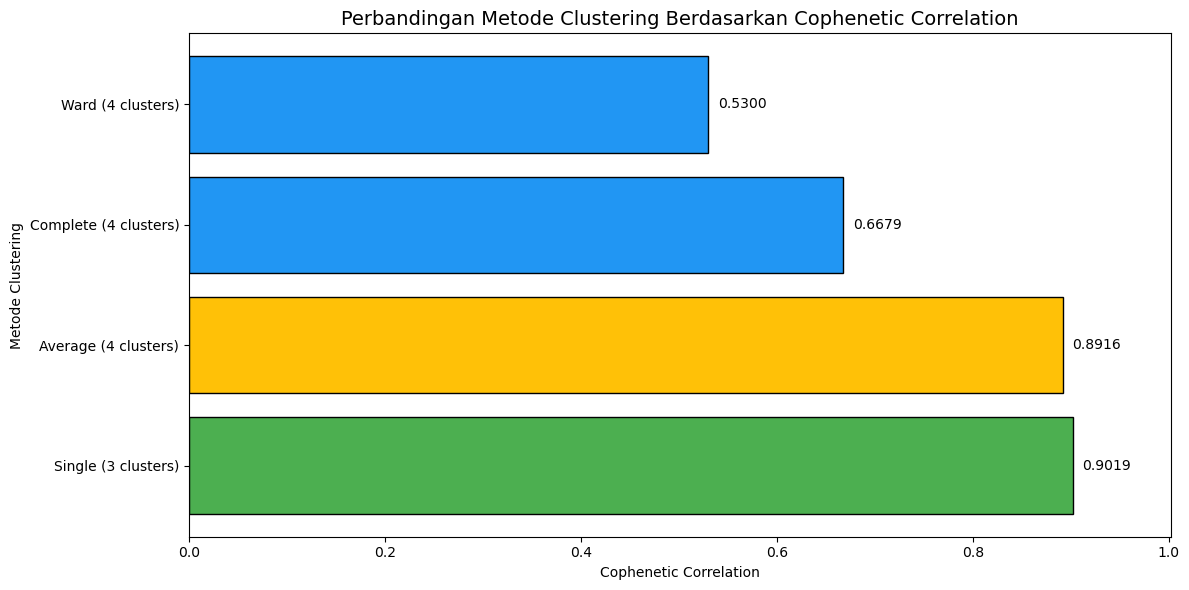

In [49]:
# Data untuk visualisasi
sorted_results['Metode (Clusters)'] = sorted_results['Metode'] + " (" + sorted_results['Jumlah Cluster'].astype(str) + " clusters)"
colors = ['#4CAF50' if i == 0 else '#FFC107' if i == 1 else '#2196F3' for i in sorted_results.index]

# Plot grafik batang horizontal
plt.figure(figsize=(12, 6))
plt.barh(sorted_results['Metode (Clusters)'], sorted_results['Cophenetic Correlation'], color=colors, edgecolor='black')

# Menambahkan nilai dan jumlah cluster pada setiap batang
for index, value in enumerate(sorted_results['Cophenetic Correlation']):
    plt.text(value + 0.01, index, f"{value:.4f}", va='center', fontsize=10)

# Menambahkan judul dan label
plt.title("Perbandingan Metode Clustering Berdasarkan Cophenetic Correlation", fontsize=14)
plt.xlabel("Cophenetic Correlation")
plt.ylabel("Metode Clustering")
plt.xlim(0, sorted_results['Cophenetic Correlation'].max() + 0.1)

# Menampilkan grafik
plt.tight_layout()
plt.show()

# Melihat Anggota Cluster Metode Average 4 Cluster

In [50]:
# Ambil hanya kolom 'Cluster' dari data_average_clusters
cluster_data = df_avg[['Cluster']]

# Gabungkan 
#  dengan cluster_data
df_combined_with_cluster = pd.concat([df_combined.reset_index(drop=True), cluster_data.reset_index(drop=True)], axis=1)
df_combined_with_cluster

,KELURAHAN,Darurat Medis,Genangan,Kebakaran,Kecelakaan,Pohon Tumbang,Rumah Roboh,KORBAN TERDAMPAK,KORBAN LUKA,KORBAN MENINGGAL,Cluster
0,airlangga,51.0,2.0,3.0,52.0,4.0,0.0,153.0,126.0,14,1
1,alun-alun contong,20.0,0.0,2.0,37.0,5.0,3.0,111.0,76.0,3,1
2,ampel,14.0,0.0,1.0,1.0,0.0,0.0,17.0,14.0,1,1
3,asem rowo,34.0,0.0,7.0,56.0,2.0,1.0,135.0,101.0,12,1
4,babat jerawat,30.0,2.0,4.0,12.0,2.0,1.0,55.0,48.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
148,wiyung,18.0,2.0,1.0,11.0,1.0,1.0,39.0,24.0,4,1
149,wonokromo,30.0,0.0,2.0,67.0,1.0,0.0,154.0,136.0,7,1
150,wonokusumo,33.0,1.0,4.0,2.0,0.0,1.0,41.0,34.0,4,1
151,wonorejo rungkut,24.0,0.0,4.0,5.0,1.0,0.0,34.0,28.0,4,1


In [51]:
df_combined_with_cluster.to_csv('Clustering Average 4 Cluster.csv', index=False)

In [52]:
# Menghitung rata-rata setiap variabel berdasarkan Cluster
cluster_summary = df_avg.groupby('Cluster').mean()

# Menghitung rata-rata total untuk setiap cluster
cluster_summary['Rata-Rata Total'] = cluster_summary.mean(axis=1)

# Menampilkan tabel hasil clustering dengan kolom rata-rata total
print("Tabel Rata-rata Setiap Variabel per Cluster dengan Rata-Rata Total:")
cluster_summary

Tabel Rata-rata Setiap Variabel per Cluster dengan Rata-Rata Total:


,Darurat Medis,Genangan,Kebakaran,Kecelakaan,Pohon Tumbang,Rumah Roboh,KORBAN TERDAMPAK,KORBAN LUKA,KORBAN MENINGGAL,Rata-Rata Total
Cluster,,,,,,,,,,
0,0.739586,-0.197010,0.784756,4.428068,5.186326,-0.197459,3.920014,4.016136,-0.060141,2.068920
1,-0.069014,-0.020103,-0.049559,-0.099197,-0.113591,-0.043320,-0.109240,-0.107154,-0.065831,-0.075223
2,4.076199,-0.591029,2.330693,0.983309,0.179335,0.431942,2.158393,2.216362,4.540625,1.813981
3,-0.226087,4.728231,0.269444,-0.668879,0.780174,6.096554,-0.018588,-0.729509,0.776362,1.223078


In [53]:
kelurahan_per_cluster = df_combined_with_cluster.groupby('Cluster')['KELURAHAN'].agg(list)

# Tampilkan hasil
for cluster, kelurahans in kelurahan_per_cluster.items():
    print(f"Cluster {cluster}: {kelurahans}")

Cluster 0: ['darmo', 'embong kaliasin', 'ketabang']
Cluster 1: ['airlangga', 'alun-alun contong', 'ampel', 'asem rowo', 'babat jerawat', 'babatan', 'balas klumprik', 'balongsari', 'bangkingan', 'banjar sugihan', 'banyu urip', 'baratajaya', 'bendul merisi', 'benowo', 'bongkaran', 'bubutan', 'bulak', 'bulak banteng', 'dr. soetomo', 'dukuh kupang', 'dukuh menanggal', 'dukuh pakis', 'dukuh setro', 'dukuh sutorejo', 'dupak', 'gayungan', 'gebang putih', 'genteng', 'genting kalianak', 'gubeng', 'gundih', 'gunung anyar', 'gunung anyar tambak', 'gunung sari', 'jagir', 'jajar tunggal', 'jambangan', 'jemur wonosari', 'jepara', 'jeruk', 'kalijudan', 'kalirungkut', 'kalisari', 'kandangan', 'kapasan', 'kapasari', 'kapasmadya baru', 'karah', 'karang pilang', 'karang poh', 'kebonsari', 'kebraon', 'kedung baruk', 'kedung cowek', 'kedungdoro', 'kedurus', 'kejawan putih tambak', 'kemayoran', 'kendangsari', 'kenjeran', 'keputih', 'keputran', 'kertajaya', 'ketintang', 'klampis ngasem', 'krembangan selatan'

# Interpretasi Cluster

**-- CLUSTER 0 --**

- **Kelurahan:** 'Darmo', 'Embong Kaliasin', 'Ketabang'
- **Rata-Rata Data:**
    1. Darurat Medis: 0.74 (tinggi)
    2. Genangan: -0.20 (rendah)
    3. Kebakaran: 0.78 (tinggi)
    4. Kecelakaan: 4.43 (sangat tinggi)
    5. Pohon Tumbang: 5.19 (sangat tinggi)
    6. Rumah Roboh: -0.20 (rendah)
    7. Korban Terkena Dampak: 3.92 (tinggi)
    8. Korban Luka: 4.02 (tinggi)
    9. Korban Meninggal: -0.06 (rendah)

- **Rata-Rata Total:** 2.07 (cukup tinggi)
    
- **Interpretasi:** Cluster ini menunjukkan tingkat bencana yang tinggi, terutama dalam kategori darurat medis, kebakaran, kecelakaan, dan pohon tumbang. Hal ini mungkin menunjukkan bahwa daerah ini lebih rentan terhadap bencana yang melibatkan kecelakaan lalu lintas dan kerusakan akibat cuaca, tetapi tidak banyak terjadi genangan atau rumah roboh. Angka KORBAN TERDAMPAK dan KORBAN LUKA yang tinggi menunjukkan bahwa meskipun jumlah kejadian bencana bervariasi, kelurahan ini sering mengalami bencana yang lebih parah. Ini mungkin mengindikasikan perlunya intervensi mitigasi yang lebih intensif.
- **Insight:** Penting untuk meningkatkan sistem pertolongan medis dan pengelolaan risiko di kawasan ini.

## -------------------------------------------------------------------------

**-- CLUSTER 1 --**

- **Kelurahan:** Banyak, termasuk 'Airlangga', 'Alun-Alun Contong', 'Ampel', dll.
- **Rata-Rata Data:**
    1. Darurat Medis: -0.07 (rendah)
    2.  Genangan: -0.02 (rendah)
    3. Kebakaran: -0.05 (rendah)
    4. Kecelakaan: -0.10 (rendah)
    5. Pohon Tumbang: -0.11 (rendah)
    6. Rumah Roboh: -0.04 (rendah)
    7. Korban Terkena Dampak: -0.11 (rendah)
    9. Korban Luka: -0.11 (rendah)
    10. Korban Meninggal: -0.07 (rendah)
- **Rata-Rata Total: -0.08 (sangat rendah)**
- **Interpretasi:** Cluster ini menunjukkan bahwa daerah ini relatif aman dengan rendahnyakejadian bencana dan angka korban. Dengan tidak adanya bencana yang signifikan, ini dapat dianggap sebagai area yang cukup baik dalam manajemen bencana atau mungkin memiliki infrastruktur yang lebih baik untuk menangani risiko. 
- **Insight:** Pemeliharaan dan peningkatan infrastruktur harus tetap menjadi fokus untuk mempertahankan status aman ini.

## -------------------------------------------------------------------------

**-- CLUSTER 2 --**

- **Kelurahan:** 'Gading', 'Tanah Kali Kedinding'
- **Rata-Rata Data:**
    1. Darurat Medis: 4.08 (sangat tinggi)
    2. Genangan: -0.59 (rendah)
    3. Kebakaran: 2.33 (tinggi)
    4. Kecelakaan: 0.98 (cukup tinggi)
    5. Pohon Tumbang: 0.18 (rendah)
    6. Rumah Roboh: 0.43 (cukup tinggi)
    7. Korban Terkena Dampak: 2.16 (tinggi)
    8. Korban Luka: 2.22 (tinggi)
    9. Korban Meninggal: 4.54 (sangat tinggi)
- **Rata-Rata Total:** 1.81 (cukup tinggi)
- **Interpretasi:** Cluster ini menunjukkan tingginya insiden darurat medis dan korban meninggal, serta tingkat kebakaran yang cukup tinggi. Meskipun insiden genangan rendah, jumlah korban menunjukkan perlunya perhatian terhadap pelayanan kesehatan darurat. 
- **Insight:** Perlu ada fokus pada peningkatan layanan darurat medis dan mitigasi risiko kebakaran di daerah ini.

## -------------------------------------------------------------------------

**-- CLUSTER 3 --**

- **Kelurahan:** 'Perak Utara'
- **Rata-Rata Data:**
    1. Darurat Medis: -0.23 (rendah)
    2. Genangan: 4.73 (sangat tinggi)
    3. Kebakaran: 0.27 (rendah)
    4. Kecelakaan: -0.67 (rendah)
    5. Pohon Tumbang: 0.78 (cukup tinggi)
    6. Rumah Roboh: 6.10 (sangat tinggi)
    7. Korban Terkena Dampak: -0.02 (rendah)
    9. Korban Luka: -0.73 (rendah)
    10. Korban Meninggal: 0.78 (cukup tinggi)
- **Rata-Rata Total:** 1.22 (cukup tinggi)
- **Interpretasi:** Cluster ini menunjukkan masalah signifikan dengan genangan dan kerobohan rumah. Ini menunjukkan bahwa daerah ini sangat rentan terhadap masalah banjir dan dampak lingkungan lainnya. 
- **Insight:** Penting untuk menerapkan solusi manajemen air hujan dan pengembangan infrastruktur yang lebih baik untuk mengurangi risiko banjir dan kerusakan pada rumah.

# Deploy Streamlit

In [54]:
#import pickle

In [55]:
# Asumsikan data yang sudah dinormalisasi tersimpan di variabel norm_all
#Z_average = linkage(norm_all, method='average')
#model_average = AgglomerativeClustering(n_clusters=4, linkage='average')
#cluster_labels_average = model_average.fit_predict(norm_all)

# Simpan linkage matrix dan label cluster ke file
#with open('linkage_average.sav', 'wb') as f:
    #pickle.dump(Z_average, f)

#with open('cluster_labels_average.sav', 'wb') as f:
    #pickle.dump(cluster_labels_average, f)

In [56]:
# Simpan norm_all ke file norm_all.pkl
#with open('norm_all.pkl', 'wb') as f:
    #pickle.dump(norm_all, f)
